# Анализ клиентов банка, отказывающихся от кредитных карт

Менеджмент банка обеспокоен тем, что все больше и больше клиентов прекращают пользоваться кредитными картами. **Цель работы** - проанализировать признаки клиентов и определить, кто с высокой вероятностью откажется от услуги, с тем, чтобы заблаговременно предложить им более качественное обслуживание и предотвратить отказ от кредитной карты.

Массив данных содержит в себе информацию о 10127 клиентах банка (**пол, возраст, семейное положение, размер кредитного лимита, количество продуктов банка, срок обслуживания** и пр.).


Источник данных: https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers?select=BankChurners.csv


В ходе исследования решается ряд **задач**:

- техническая подготовка данных (проверка на дубликаты и пропуски, переименование столбцов и т.п.);
- проведение анализа признаков в разрезе целевой переменной оттока;
- определение корреляции между признаками и целевой переменной;
- проведение статистических тестов для сравнения групп с оттоком и без по ряду признаков;
- проведение процедур кодирования и стандартизации данных;
- определение значимых признаков;
- построение моделей прогнозирования: логистической регрессии, решающего дерева, случайного леса, градиентного бустинга;
- выбор лучшей модели на основе метрики ROC_AUC, F1, recall и проверка на тестовой выборке;
- кластеризация клиентов на основе значимых признаков и рекомендации по взаимодействию со стороны сотрудников банка.


>[Анализ клиентов банка, отказывающихся от кредитных карт](#scrollTo=nvo0rU77u1uB)

>>[Подготовка данных](#scrollTo=aEXK5WcV30IH)

>>>[Анализ признаков](#scrollTo=9vg0NCfM34lZ)

>>>>[Проверка статистических гипотез о разницах между группами](#scrollTo=cbA_UQsa7R-X)

>>>>[Вывод](#scrollTo=HF-kzAPASEHu)

>>>[Кодирование переменных](#scrollTo=8HUUGlMKcoOa)

>>>[Удаление столбцов](#scrollTo=r9_4p_XPi9G0)

>>>[Корреляция признаков](#scrollTo=BWVYUG-qXj2j)

>>>[Разбивка данных на выборки](#scrollTo=aeZ3Q1tsAUl3)

>>>[Масштабирование признаков](#scrollTo=ocY0p6nQGEqT)

>>>[Вывод](#scrollTo=MlqernODJyXJ)

>>[Обучение моделей](#scrollTo=N7-AxlHFKmJW)

>>>[Логистическая регрессия](#scrollTo=4NKBr7T2_7Yg)

>>>[Модель решающего дерева](#scrollTo=w_xMciDaKeXH)

>>>[Модель случайного леса](#scrollTo=QsCBAX8yLL1j)

>>>[CatBoost](#scrollTo=rzwmYZIhMEPv)

>>>[LightGBM](#scrollTo=ULPDNQGtMUtu)

>>>[Влияние признаков](#scrollTo=n6m88JIIjzFN)

>>>[Вывод](#scrollTo=zpYrhbw8T1fc)

>>[Кластеризация клиентов](#scrollTo=S-4dQ7TrU4cK)

>>>[Вывод](#scrollTo=RrXaPGwzMnA8)

>>[Рекомендации по работе с клиентами](#scrollTo=hq1KRMpmexfT)

>>[Основные результаты](#scrollTo=PPu1HvC9_msL)



## Подготовка данных

Импорт библиотек, которые потребуются для выполнения исследования, и загрузка датасета:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
import lightgbm
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, make_scorer, roc_auc_score, roc_curve, recall_score, precision_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('BankChurners.csv', sep=';')

Посмотрим на данные в первом приближении:

In [ ]:
pd.options.display.max_columns = 100

In [ ]:
df.head()

CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  Total_Relationship_Count  Months_Inactive_12_mon  \
0              39                         5                       1   
1              44                         6                       1   
2              36                         4                       1   
3              34                         3                       4   
4              21                         5                       1   

   Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  \
0                      3       12691.0                  777          11914.0   
1                      2        8256.0                  864           7392.0   
2                      0        3418.0                    0           3418.0   
3                      1        3313.0                 2517            796.0   
4                      0        4716.0                    0           4716.0   

   Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
0                 1.335             1144              42                1.625   
1                 1.541             1291              33                3.714   
2                 2.594             1887              20                2.333   
3                 1.405             1171              20                2.333   
4                 2.175              816              28                2.500   

   Avg_Utilization_Ratio  
0                  0.061  
1                  0.105  
2                  0.000  
3                  0.760  
4                  0.000

In [ ]:
df = df.rename(columns = lambda x: x.lower())

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   clientnum                 10127 non-null  int64  
 1   attrition_flag            10127 non-null  object 
 2   customer_age              10127 non-null  int64  
 3   gender                    10127 non-null  object 
 4   dependent_count           10127 non-null  int64  
 5   education_level           10127 non-null  object 
 6   marital_status            10127 non-null  object 
 7   income_category           10127 non-null  object 
 8   card_category             10127 non-null  object 
 9   months_on_book            10127 non-null  int64  
 10  total_relationship_count  10127 non-null  int64  
 11  months_inactive_12_mon    10127 non-null  int64  
 12  contacts_count_12_mon     10127 non-null  int64  
 13  credit_limit              10127 non-null  float64
 14  total_

В датасете содержатся данные о 10127 клиентах и 21 признаке. Пропусков в столбцах нет.

Названия признаков означают следующее:

- **clientnum** - уникальный номер клиента;                 
- **attrition_flag** - действующий или ушедший клиент;             
- **customer_age** - возраст;             
- **gender** - пол;                    
- **dependent_count** - число иждивенцев;         
- **education_level** - уровень образования;           
- **marital_status** - семейное положение;            
- **income_category** - уровень годового дохода;           
- **card_category** - тип кредитной карты;             
- **months_on_book** - количество месяцев, которое является клиентом банка;             
- **total_relationship_count** - общее количество продуктов у клиента;
- **months_inactive_12_mon** - количество месяцев за последний год, в течение которых клиент был неактивным;   
- **contacts_count_12_mon** - количество контаков за последний год;     
- **credit_limit** - лимит по кредитной карте;             
- **total_revolving_bal** - размер возобновляемого остатка;      
- **avg_open_to_buy** - средняя за последние 12 месяцев разница между кредитным лимитом и текущим балансом;         
- **total_amt_chng_q4_q1** - разница в сумме транзакций (4-й квартал по сравнению с 1-м);     
- **total_trans_amt** - общая сумма транзакций за последние 12 месяцев;            
- **total_trans_ct** общее число транзакций за последние 12 месяцев;                        
- **total_ct_chng_q4_q1** - разница в числе транзакций (4-й квартал по сравнению с 1-м);           
- **avg_utilization_ratio** - средний коэффициент использования карты.    

Полных дубликатов в датафрейме нет:

In [ ]:
df.duplicated().sum()

0

### Анализ признаков

Теперь рассмотрим признаки по отдельности и проведем над ними изменения, если потребуется. Начнем с целевого показателя - оттока.

**attrition_flag - действующий или ушедший клиент**

In [ ]:
display(df['attrition_flag'].value_counts())
display(df['attrition_flag'].value_counts(normalize = True))

attrition_flag
Existing Customer    8500
Attrited Customer    1627
Name: count, dtype: int64

attrition_flag
Existing Customer    0.83934
Attrited Customer    0.16066
Name: proportion, dtype: float64

Итого имеем 16% попавших в отток клиентов. Классы несбалансированы.

Для удобства заменим текстовое значение признака на числовое. Пусть клиенты из группы оттока обозначаются 1, а остальные - 0:

In [ ]:
df.loc[df['attrition_flag'] == 'Attrited Customer', 'attrition_flag'] = 1
df.loc[df['attrition_flag'] == 'Existing Customer', 'attrition_flag'] = 0

In [ ]:
df['attrition_flag'].mean()

0.1606596227905599

Разобьем датасет на две группы - тех, кто ушел в отток, и тех, кто не ушел:

In [ ]:
churn = df.loc[df['attrition_flag'] == 1]
nonchurn = df.loc[df['attrition_flag'] == 0]

Будем рассматривать каждый признак в разрезе оттока.

**clientnum** - уникальный номер клиента

In [ ]:
df['clientnum'].nunique()

10127

Повторяющихся id клиентов нет.

**customer_age - возраст**

In [ ]:
df['customer_age'].describe()

count    10127.000000
mean        46.325960
std          8.016814
min         26.000000
25%         41.000000
50%         46.000000
75%         52.000000
max         73.000000
Name: customer_age, dtype: float64

Самому молодому клиенту 26 лет, а самому возрастному - 73 года. Средний возраст составляет почти 49 лет, стандартное отклонение - 8 лет.

Построим график распределения:

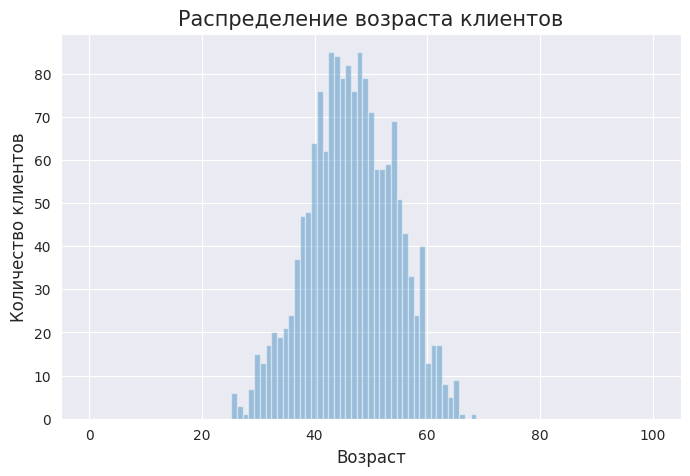

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))
fig = sns.distplot(churn['customer_age'], kde = False, bins = np.linspace(start = 0, stop = 100, num = 100))
fig.set_title("Распределение возраста клиентов", fontsize = 15)
fig.set_xlabel("Возраст", fontsize = 12)
fig.set_ylabel("Количество клиентов", fontsize = 12)
plt.show()

Распределение выглядит как нормальное.

Посмотрим на график возраста в группах с оттоком и без:

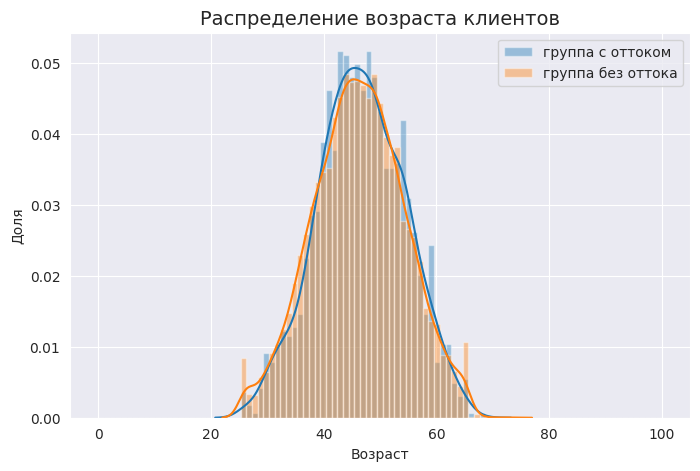

In [ ]:
plt.figure(figsize=(8, 5))
fig1 = sns.distplot(churn['customer_age'], kde=True, bins=np.linspace(start=0, stop=100, num=100), label='группа с оттоком')
fig2 = sns.distplot(nonchurn['customer_age'], kde=True, bins = np.linspace(start=0, stop=100, num=100), label='группа без оттока')
fig2.set_title("Распределение возраста клиентов", fontsize=14)
fig2.set_ylabel("Доля", fontsize=10)
fig2.set_xlabel("Возраст")
plt.legend()
plt.show()

In [ ]:
df.groupby('attrition_flag')['customer_age'].agg(['mean', 'std'])

mean       std
attrition_flag                     
0               46.262118  8.081157
1               46.659496  7.665652

Разницы между группами по признаку возраста практически не видно.

**gender - пол**

In [ ]:
df['gender'].value_counts(normalize=True)

gender
F    0.529081
M    0.470919
Name: proportion, dtype: float64

47% выборки составляют мужчины, 53% - женщины.

In [ ]:
#вспомогательная функция для отображения процентов на графике
#принимает на вход название графика, сдвиг надписи по горизонтали и по вертикали

def show_percent(figure, shift, height):
    totals = []
    for i in figure.patches:
        totals.append(i.get_height())

    total = sum(totals)

    for i in figure.patches:
        figure.text(i.get_x() + shift, i.get_height() + height, \
            str(round((i.get_height() / total) * 100, 2)) + '%', fontsize=8, color='black')

In [ ]:
gend_c = churn.groupby(by='gender').agg({'clientnum': 'count'}).reset_index().rename(columns = {'clientnum': 'n'})
gend_nc = nonchurn.groupby(by='gender').agg({'clientnum': 'count'}).reset_index().rename(columns = {'clientnum': 'n'})

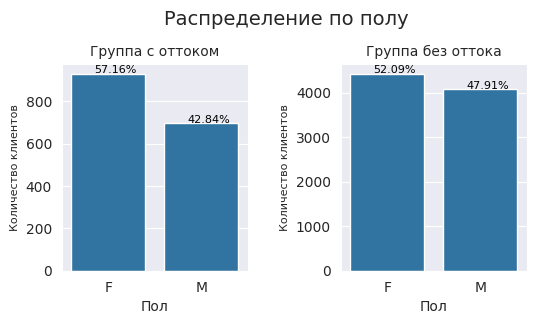

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
plt.subplots_adjust(wspace = 0.5, top=0.8)

fig.suptitle('Распределение по полу', fontsize=14)

fig1 = sns.barplot(ax=axes[0], x="gender", y="n", data=gend_c)
fig1.set_title("Группа с оттоком", fontsize=10)
fig1.set_ylabel("Количество клиентов", fontsize=8)
fig1.set_xlabel("Пол")
show_percent(fig1, 0.25, 3)

fig2 = sns.barplot(ax=axes[1], x="gender", y="n", data=gend_nc)
fig2.set_title("Группа без оттока", fontsize=10)
fig2.set_ylabel("Количество клиентов", fontsize=8)
fig2.set_xlabel("Пол")
show_percent(fig2, 0.25, 17)

plt.show()

В группе с отоком доля женщин выше (57% против 52% в группе без оттока).

**dependent_count - число иждивенцев**

In [ ]:
df['dependent_count'].value_counts(normalize=True).sort_index()

dependent_count
0    0.089266
1    0.181495
2    0.262170
3    0.269774
4    0.155426
5    0.041868
Name: proportion, dtype: float64

Примерно у четверти клиентов по двое или трое иждивенцев. У 18% - 1, у 15% - 4, у 9% - нет, у 4% - 5.

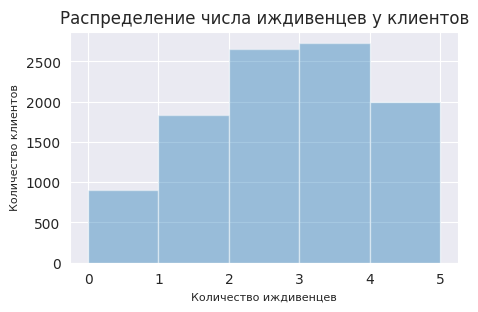

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize=(5, 3))
fig = sns.distplot(df['dependent_count'], kde = False, bins = np.linspace(start=0, stop=5, num=6))
fig.set_title("Распределение числа иждивенцев у клиентов", fontsize=12)
fig.set_xlabel("Количество иждивенцев", fontsize=8)
fig.set_ylabel("Количество клиентов", fontsize=8)
plt.show()

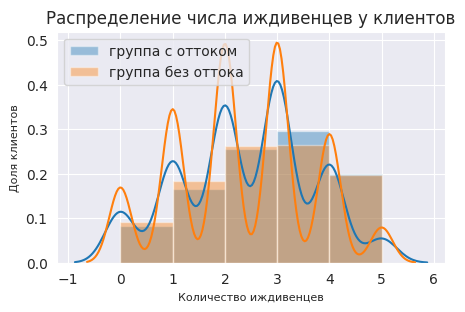

In [ ]:
plt.figure(figsize=(5, 3))
fig1 = sns.distplot(churn['dependent_count'], kde=True, bins = np.linspace(start=0, stop=5, num=6), label='группа с оттоком')
fig2 = sns.distplot(nonchurn['dependent_count'], kde=True, bins = np.linspace(start=0, stop=5, num=6), label='группа без оттока')
fig2.set_title("Распределение числа иждивенцев у клиентов", fontsize=12)
fig2.set_xlabel("Количество иждивенцев", fontsize=8)
fig2.set_ylabel("Доля клиентов", fontsize=8)
plt.legend()
plt.show()

Существенной разницы между группами опять не наблюдается.

In [ ]:
df.groupby('attrition_flag')['dependent_count'].agg(['mean', 'std'])

mean       std
attrition_flag                    
0               2.335412  1.303229
1               2.402581  1.275010

**education_level - уровень образования**

In [ ]:
df['education_level'].value_counts(normalize=True)

education_level
Graduate         0.308877
High School      0.198776
Unknown          0.149995
Uneducated       0.146835
College          0.100030
Post-Graduate    0.050953
Doctorate        0.044534
Name: proportion, dtype: float64

У 31% высшее образование, 20% окончили только школу, без образования 14,6%, выпускников колледжа 10%, закончивших аспирантуру 5%, докторантуру - 4,4%.

In [ ]:
ed = df.groupby(by='education_level').agg({'clientnum':'count'}).reset_index()\
          .rename(columns = {'clientnum':'n'}).sort_values(by='n', ascending=False)

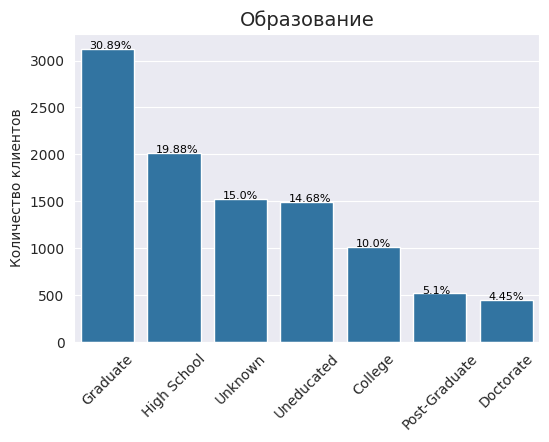

In [ ]:
plt.figure(figsize=(6, 4))
fig = sns.barplot(x="education_level", y="n", data=ed);
fig.set_title("Образование", fontsize = 14)
fig.set_ylabel("Количество клиентов", fontsize = 10)
fig.set_xlabel("")
plt.xticks(rotation=45)
show_percent(fig, 0.13, 1.0)

Теперь посмотрим, каково соотношение клиентов по уровню образования в разрезе оттока:

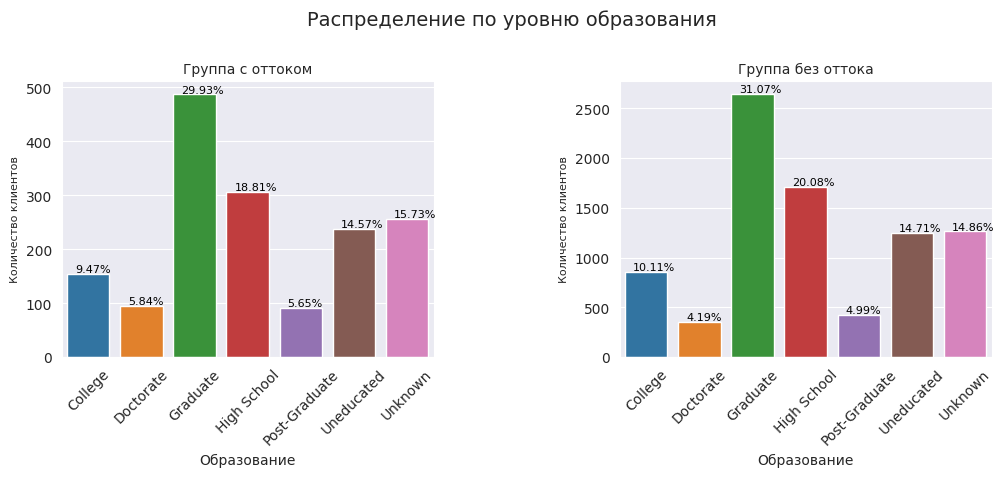

In [ ]:
ed_ch = churn.groupby(by='education_level').agg({'clientnum':'count'}).reset_index()\
          .rename(columns = {'clientnum':'n'})
ed_nch = nonchurn.groupby(by='education_level').agg({'clientnum':'count'}).reset_index()\
          .rename(columns = {'clientnum':'n'})

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plt.subplots_adjust(wspace = 0.5, top=0.8)

fig.suptitle('Распределение по уровню образования', fontsize=14)

fig1 = sns.barplot(ax=axes[0], x="education_level", y="n", data=ed_ch, hue="education_level")
fig1.set_title("Группа с оттоком", fontsize=10)
fig1.set_ylabel("Количество клиентов", fontsize=8)
fig1.set_xlabel("Образование")
show_percent(fig1, 0.15, 3)
fig1.set_xticklabels(fig1.get_xticklabels(), rotation=45)

fig2 = sns.barplot(ax=axes[1], x="education_level", y="n", data=ed_nch, hue="education_level")
fig2.set_title("Группа без оттока", fontsize=10)
fig2.set_ylabel("Количество клиентов", fontsize=8)
fig2.set_xlabel("Образование")
show_percent(fig2, 0.15, 17)
fig2.set_xticklabels(fig2.get_xticklabels(), rotation=45)

plt.show()

И вновь между группами не видно значительной разницы.

**marital_status - семейное положение**

In [ ]:
df['marital_status'].value_counts(normalize=True)

marital_status
Married     0.462822
Single      0.389355
Unknown     0.073961
Divorced    0.073862
Name: proportion, dtype: float64

46% клиентов состоят в браке, 40% - не женаты, 7% разведены, и у 7% семейное положение не известно.

In [ ]:
mar = df.groupby(by='marital_status').agg({'clientnum':'count'}).reset_index()\
          .rename(columns = {'clientnum':'n'}).sort_values(by='n', ascending=False)

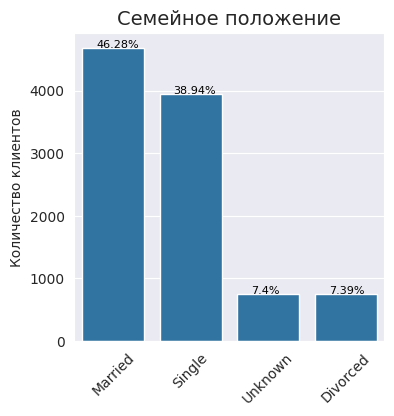

In [ ]:
plt.figure(figsize=(4, 4))
fig = sns.barplot(x="marital_status", y="n", data=mar);
fig.set_title("Семейное положение", fontsize = 14)
fig.set_ylabel("Количество клиентов", fontsize = 10)
fig.set_xlabel("")
plt.xticks(rotation=45)
show_percent(fig, 0.18, 2)

Теперь посмотрим, каково соотношение клиентов по семейному положению в разрезе оттока:

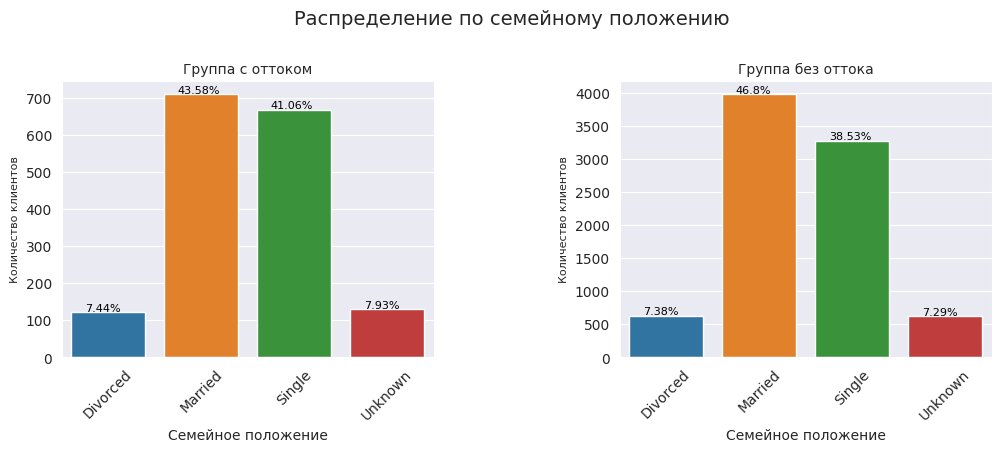

In [ ]:
mar_ch = churn.groupby(by='marital_status').agg({'clientnum':'count'}).reset_index()\
          .rename(columns = {'clientnum':'n'})
mar_nch = nonchurn.groupby(by='marital_status').agg({'clientnum':'count'}).reset_index()\
          .rename(columns = {'clientnum':'n'})

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plt.subplots_adjust(wspace = 0.5, top=0.8)

fig.suptitle('Распределение по семейному положению', fontsize=14)

fig1 = sns.barplot(ax=axes[0], x="marital_status", y="n", data=mar_ch, hue='marital_status')
fig1.set_title("Группа с оттоком", fontsize=10)
fig1.set_ylabel("Количество клиентов", fontsize=8)
fig1.set_xlabel("Семейное положение")
show_percent(fig1, 0.15, 3)
fig1.set_xticklabels(fig1.get_xticklabels(), rotation=45)

fig2 = sns.barplot(ax=axes[1], x="marital_status", y="n", data=mar_nch, hue='marital_status')
fig2.set_title("Группа без оттока", fontsize=10)
fig2.set_ylabel("Количество клиентов", fontsize=8)
fig2.set_xlabel("Семейное положение")
show_percent(fig2, 0.15, 17)
fig2.set_xticklabels(fig2.get_xticklabels(), rotation=45)

plt.show()

В группе без оттока на 3,3% выше доля женатых людей.

**income_category - уровень годового дохода**

In [ ]:
df['income_category'].value_counts(normalize=True)

income_category
Less than $40K    0.351634
$40K - $60K       0.176755
$80K - $120K      0.151575
$60K - $80K       0.138442
Unknown           0.109805
$120K +           0.071788
Name: proportion, dtype: float64

In [ ]:
inc = df.groupby(by='income_category').agg({'clientnum':'count'}).reset_index()\
          .rename(columns = {'clientnum':'n'}).sort_values(by='n', ascending=False)

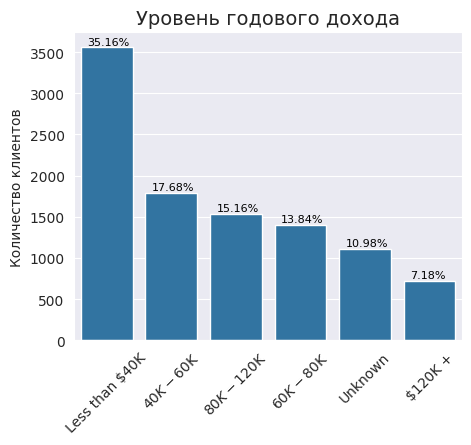

In [ ]:
plt.figure(figsize=(5, 4))
fig = sns.barplot(x="income_category", y="n", data=inc);
fig.set_title("Уровень годового дохода", fontsize = 14)
fig.set_ylabel("Количество клиентов", fontsize = 10)
fig.set_xlabel("")
plt.xticks(rotation=45)
show_percent(fig, 0.1, 30)

Расмотрим, каково соотношение клиентов по уровню дохода в разрезе оттока:

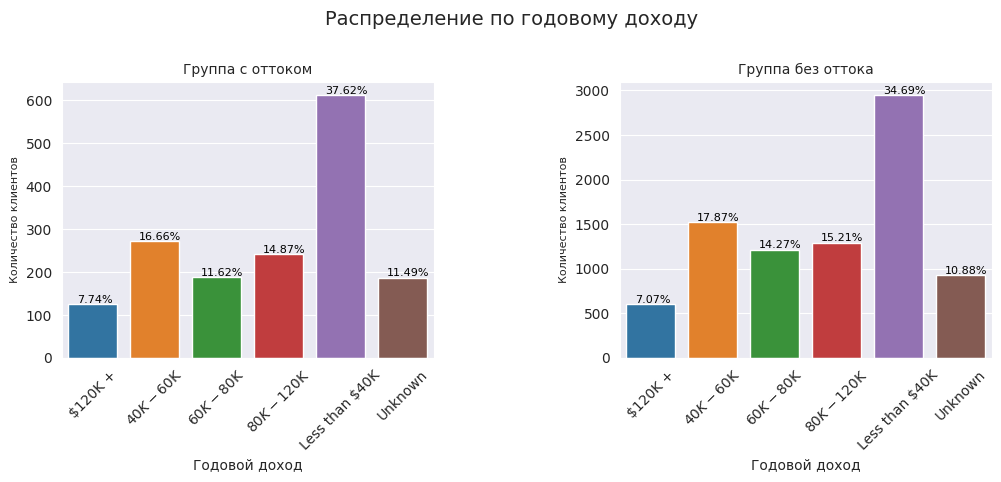

In [ ]:
inc_ch = churn.groupby(by='income_category').agg({'clientnum':'count'}).reset_index()\
          .rename(columns = {'clientnum':'n'})
inc_nch = nonchurn.groupby(by='income_category').agg({'clientnum':'count'}).reset_index()\
          .rename(columns = {'clientnum':'n'})

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plt.subplots_adjust(wspace = 0.5, top=0.8)

fig.suptitle('Распределение по годовому доходу', fontsize=14)

fig1 = sns.barplot(ax=axes[0], x="income_category", y="n", data=inc_ch, hue='income_category')
fig1.set_title("Группа с оттоком", fontsize=10)
fig1.set_ylabel("Количество клиентов", fontsize=8)
fig1.set_xlabel("Годовой доход")
show_percent(fig1, 0.15, 3)
fig1.set_xticklabels(fig1.get_xticklabels(), rotation=45)

fig2 = sns.barplot(ax=axes[1], x="income_category", y="n", data=inc_nch, hue='income_category')
fig2.set_title("Группа без оттока", fontsize=10)
fig2.set_ylabel("Количество клиентов", fontsize=8)
fig2.set_xlabel("Годовой доход")
show_percent(fig2, 0.15, 17)
fig2.set_xticklabels(fig2.get_xticklabels(), rotation=45)

plt.show()

В группе без оттока на 3% ниже доля клиентов с самым низким доходом (менее 40 тыс. долл) и выше все остальные: на 1% - с доходом 40-60 тыс. долл, на 3% - с доходом 60-80 тыс. долл, на 0,4% - с доходом с доходом 80-120 тыс. долл и на 0,7% - с доходом от 120 тыс. долл.

**card_category - тип кредитной карты**

In [ ]:
df['card_category'].value_counts(normalize=True)

card_category
Blue        0.931767
Silver      0.054804
Gold        0.011455
Platinum    0.001975
Name: proportion, dtype: float64

В основном все пользуются голубыми картами. 5,5% - серебряными. Золотыми - 1%, платиновыми - 0,2%.

В разрезе оттока:

In [ ]:
churn['card_category'].value_counts(normalize=True)

card_category
Blue        0.933620
Silver      0.050400
Gold        0.012907
Platinum    0.003073
Name: proportion, dtype: float64

In [ ]:
nonchurn['card_category'].value_counts(normalize=True)

card_category
Blue        0.931412
Silver      0.055647
Gold        0.011176
Platinum    0.001765
Name: proportion, dtype: float64

Существенной разницы между группами нет.

**months_on_book - количество месяцев, которое является клиентом банка**

In [ ]:
df['months_on_book'].describe()

count    10127.000000
mean        35.928409
std          7.986416
min         13.000000
25%         31.000000
50%         36.000000
75%         40.000000
max         56.000000
Name: months_on_book, dtype: float64

"Стаж" клиентов - от 13 до 56 месяцев. Среднее значение совпадает с медианой - 36 месяцев, стандартное отклонение - 8 месяцев.

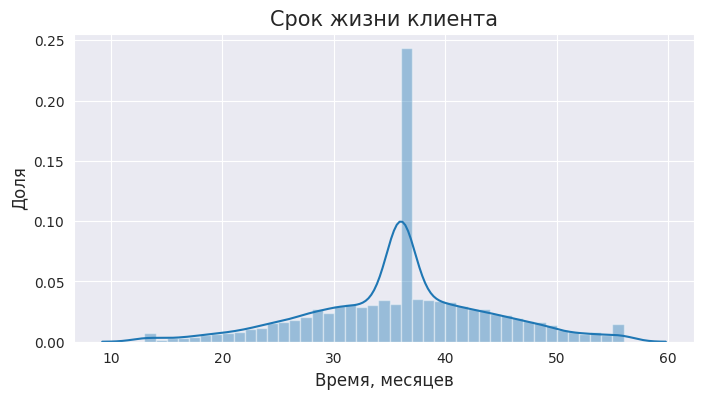

In [ ]:
plt.figure(figsize=(8, 4))
fig = sns.distplot(df['months_on_book'], kde = True, bins = len(df['months_on_book'].unique()) - 1)
fig.set_title("Срок жизни клиента", fontsize = 15)
fig.set_xlabel("Время, месяцев", fontsize = 12)
fig.set_ylabel("Доля", fontsize = 12)

plt.show()

In [ ]:
df['months_on_book'].value_counts().head(3)

months_on_book
36    2463
37     358
34     353
Name: count, dtype: int64

Создается впечатление, что в датасет либо специально собрали клиентов со сроком "жизни"ровно 3 года, либо в сборе данных есть какая-то ошибка.

Посмотрим, что происходит в разрезе оттока:

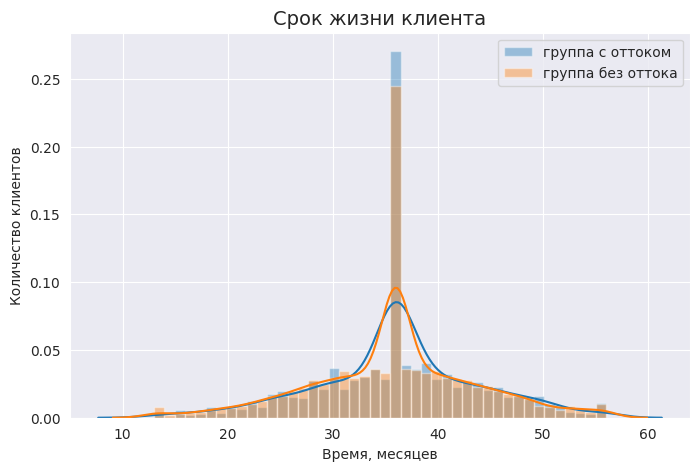

In [ ]:
plt.figure(figsize=(8, 5))
fig1 = sns.distplot(churn['months_on_book'], kde = True, bins = len(churn['months_on_book'].unique()), label = 'группа с оттоком')
fig2 = sns.distplot(nonchurn['months_on_book'], kde = True, bins = len(churn['months_on_book'].unique()), label = 'группа без оттока')
fig2.set_title("Срок жизни клиента", fontsize = 14)
fig2.set_ylabel("Количество клиентов", fontsize = 10)
fig2.set_xlabel("Время, месяцев")
plt.legend()
plt.show()

In [ ]:
df.groupby('attrition_flag')['months_on_book'].agg(['mean', 'std'])

mean       std
attrition_flag                     
0               35.880588  8.021810
1               36.178242  7.796548

И вновь значительной разницы между группами нет.

**total_relationship_count - общее количество продуктов у клиента**

In [ ]:
df['total_relationship_count'].value_counts(normalize=True).sort_index()

total_relationship_count
1    0.089859
2    0.122741
3    0.227609
4    0.188802
5    0.186729
6    0.184260
Name: proportion, dtype: float64

In [ ]:
prod = df.groupby(by='total_relationship_count').agg({'clientnum':'count'}).reset_index()\
          .rename(columns = {'clientnum':'n'}).sort_values(by='n', ascending=False)

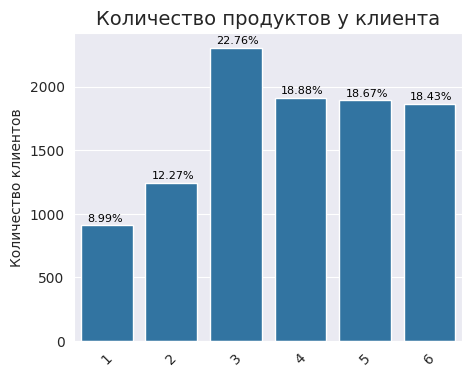

In [ ]:
plt.figure(figsize=(5, 4))
fig = sns.barplot(x="total_relationship_count", y="n", data=prod);
fig.set_title("Количество продуктов у клиента", fontsize = 14)
fig.set_ylabel("Количество клиентов", fontsize = 10)
fig.set_xlabel("")
plt.xticks(rotation=45)
show_percent(fig, 0.1, 30)

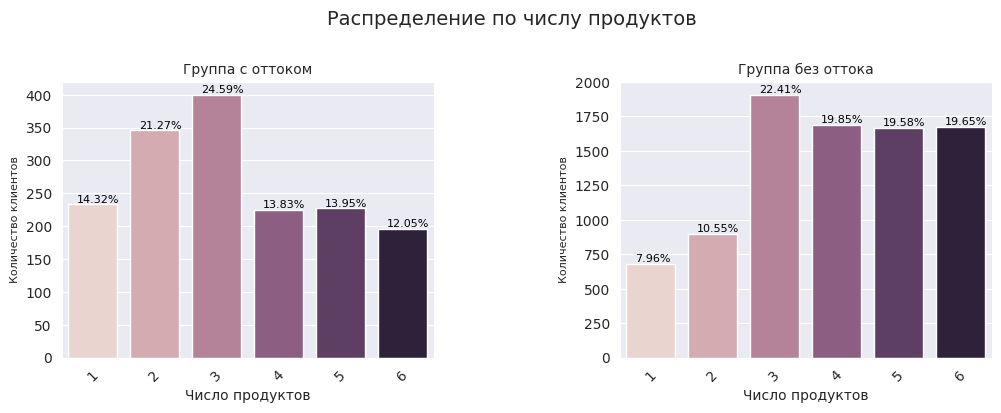

In [ ]:
prod_ch = churn.groupby(by='total_relationship_count').agg({'clientnum':'count'}).reset_index()\
          .rename(columns = {'clientnum':'n'})
prod_nch = nonchurn.groupby(by='total_relationship_count').agg({'clientnum':'count'}).reset_index()\
          .rename(columns = {'clientnum':'n'})

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plt.subplots_adjust(wspace = 0.5, top=0.8)

fig.suptitle('Распределение по числу продуктов', fontsize=14)

fig1 = sns.barplot(ax=axes[0], x="total_relationship_count", y="n", data=prod_ch, hue="total_relationship_count", legend=False)
fig1.set_title("Группа с оттоком", fontsize=10)
fig1.set_ylabel("Количество клиентов", fontsize=8)
fig1.set_xlabel("Число продуктов")
show_percent(fig1, 0.15, 3)
fig1.set_xticklabels(fig1.get_xticklabels(), rotation=45)

fig2 = sns.barplot(ax=axes[1], x="total_relationship_count", y="n", data=prod_nch, hue="total_relationship_count", legend=False)
fig2.set_title("Группа без оттока", fontsize=10)
fig2.set_ylabel("Количество клиентов", fontsize=8)
fig2.set_xlabel("Число продуктов")
show_percent(fig2, 0.15, 17)
fig2.set_xticklabels(fig2.get_xticklabels(), rotation=45)

plt.show()

Наконец нашелся признак, для которого распределения существенно отличаются. Так, в группе без оттока выше доля клиентов с четырьмя (20% против 14%), пятью (19,5% против 14%) и шестью (19,5% против 12%). Напротив, гораздо ниже доля клиентов с одним продуктом (10,5% против 21%) или двумя (8% против 14,3%).

In [ ]:
df.groupby('attrition_flag')['total_relationship_count'].agg(['mean', 'std'])

mean       std
attrition_flag                    
0               3.914588  1.528949
1               3.279656  1.577782

Разница между средними составляет 0,635 (в группе без оттока выше).

**months_inactive_12_mon - количество месяцев за последний год, в течение которых клиент был неактивным**

In [ ]:
df['months_inactive_12_mon'].value_counts(normalize=True).sort_index()

months_inactive_12_mon
0    0.002864
1    0.220500
2    0.324084
3    0.379777
4    0.042954
5    0.017577
6    0.012244
Name: proportion, dtype: float64

In [ ]:
inact = df.groupby(by='months_inactive_12_mon').agg({'clientnum':'count'}).reset_index()\
          .rename(columns = {'clientnum':'n'}).sort_values(by='n', ascending=False)

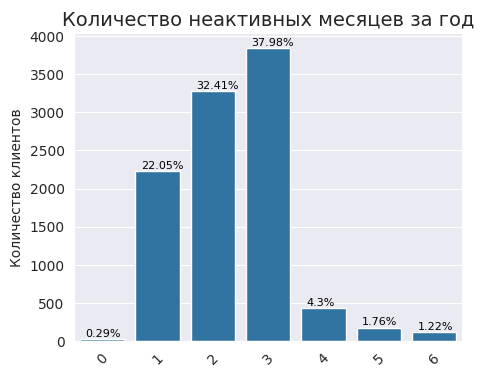

In [ ]:
plt.figure(figsize=(5, 4))
fig = sns.barplot(x="months_inactive_12_mon", y="n", data=inact);
fig.set_title("Количество неактивных месяцев за год", fontsize = 14)
fig.set_ylabel("Количество клиентов", fontsize = 10)
fig.set_xlabel("")
plt.xticks(rotation=45)
show_percent(fig, 0.1, 30)

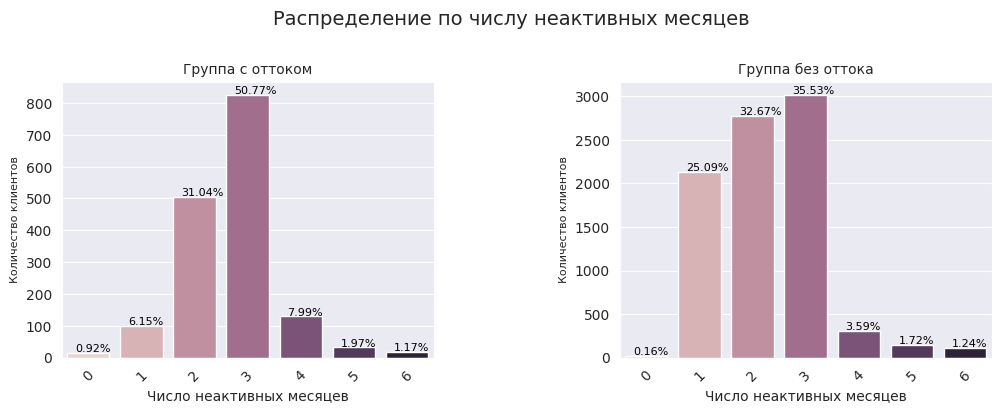

In [ ]:
inact_ch = churn.groupby(by='months_inactive_12_mon').agg({'clientnum':'count'}).reset_index()\
          .rename(columns = {'clientnum':'n'})
inact_nch = nonchurn.groupby(by='months_inactive_12_mon').agg({'clientnum':'count'}).reset_index()\
          .rename(columns = {'clientnum':'n'})

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plt.subplots_adjust(wspace = 0.5, top=0.8)

fig.suptitle('Распределение по числу неактивных месяцев', fontsize=14)

fig1 = sns.barplot(ax=axes[0], x="months_inactive_12_mon", y="n", data=inact_ch, hue="months_inactive_12_mon", legend=False)
fig1.set_title("Группа с оттоком", fontsize=10)
fig1.set_ylabel("Количество клиентов", fontsize=8)
fig1.set_xlabel("Число неактивных месяцев")
show_percent(fig1, 0.15, 3)
fig1.set_xticklabels(fig1.get_xticklabels(), rotation=45)

fig2 = sns.barplot(ax=axes[1], x="months_inactive_12_mon", y="n", data=inact_nch, hue="months_inactive_12_mon", legend=False)
fig2.set_title("Группа без оттока", fontsize=10)
fig2.set_ylabel("Количество клиентов", fontsize=8)
fig2.set_xlabel("Число неактивных месяцев")
show_percent(fig2, 0.15, 17)
fig2.set_xticklabels(fig2.get_xticklabels(), rotation=45)

plt.show()

В группе с оттоком на 4, 5 и 6 неактивных месяцев сумарно приходится более 11% клиентов, а в группе без оттока - только 6,5%. Также в группе с оттоком значительно больше клиентов с тремя месяцами неактивности (51% против 35,5%).

In [ ]:
df.groupby('attrition_flag')['months_inactive_12_mon'].agg(['mean', 'std'])

mean       std
attrition_flag                    
0               2.273765  1.016741
1               2.693301  0.899623

Разница между средними составляет 0,42 (выше в группе с оттоком).

**contacts_count_12_mon - количество контаков за последний год**

In [ ]:
df['contacts_count_12_mon'].value_counts(normalize=True).sort_index()

contacts_count_12_mon
0    0.039400
1    0.148020
2    0.318653
3    0.333761
4    0.137454
5    0.017379
6    0.005332
Name: proportion, dtype: float64

In [ ]:
cont = df.groupby(by='contacts_count_12_mon').agg({'clientnum':'count'}).reset_index()\
          .rename(columns = {'clientnum':'n'}).sort_values(by='n', ascending=False)

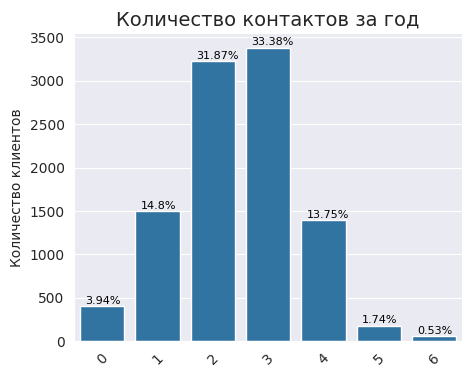

In [ ]:
plt.figure(figsize=(5, 4))
fig = sns.barplot(x="contacts_count_12_mon", y="n", data=cont);
fig.set_title("Количество контактов за год", fontsize = 14)
fig.set_ylabel("Количество клиентов", fontsize = 10)
fig.set_xlabel("")
plt.xticks(rotation=45)
show_percent(fig, 0.1, 30)

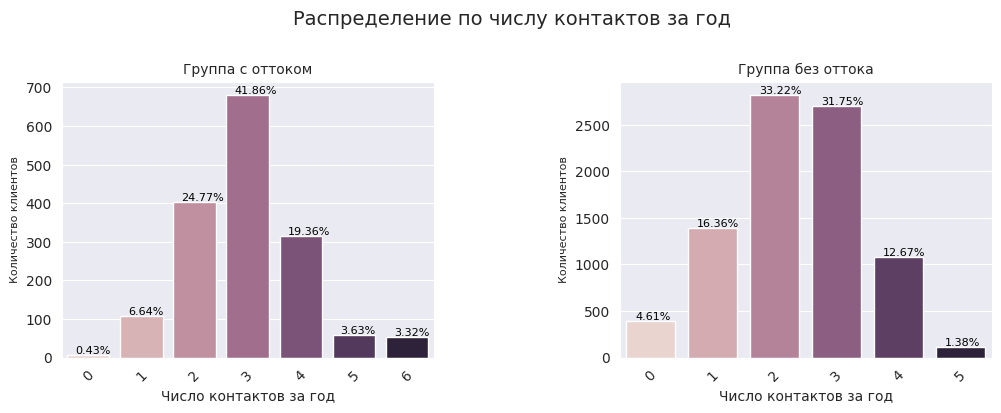

In [ ]:
cont_ch = churn.groupby(by='contacts_count_12_mon').agg({'clientnum':'count'}).reset_index()\
          .rename(columns = {'clientnum':'n'})
cont_nch = nonchurn.groupby(by='contacts_count_12_mon').agg({'clientnum':'count'}).reset_index()\
          .rename(columns = {'clientnum':'n'})

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plt.subplots_adjust(wspace = 0.5, top=0.8)

fig.suptitle('Распределение по числу контактов за год', fontsize=14)

fig1 = sns.barplot(ax=axes[0], x="contacts_count_12_mon", y="n", data=cont_ch, hue="contacts_count_12_mon", legend=False)
fig1.set_title("Группа с оттоком", fontsize=10)
fig1.set_ylabel("Количество клиентов", fontsize=8)
fig1.set_xlabel("Число контактов за год")
show_percent(fig1, 0.15, 3)
fig1.set_xticklabels(fig1.get_xticklabels(), rotation=45)

fig2 = sns.barplot(ax=axes[1], x="contacts_count_12_mon", y="n", data=cont_nch, hue="contacts_count_12_mon", legend=False)
fig2.set_title("Группа без оттока", fontsize=10)
fig2.set_ylabel("Количество клиентов", fontsize=8)
fig2.set_xlabel("Число контактов за год")
show_percent(fig2, 0.15, 17)
fig2.set_xticklabels(fig2.get_xticklabels(), rotation=45)

plt.show()

Видно, что в группе с оттоком количество контактов в среднем выше.

In [ ]:
df.groupby('attrition_flag')['contacts_count_12_mon'].agg(['mean', 'std'])

mean       std
attrition_flag                    
0               2.356353  1.081436
1               2.972342  1.090537

**credit_limit - лимит по кредитной карте**

In [ ]:
df['credit_limit'].describe()

count    10127.000000
mean      8631.953698
std       9088.776650
min       1438.300000
25%       2555.000000
50%       4549.000000
75%      11067.500000
max      34516.000000
Name: credit_limit, dtype: float64

Средний размер лимита - 8631 долл., медианный - 4549, что значительно ниже. Это говорит о скошенности распределения.

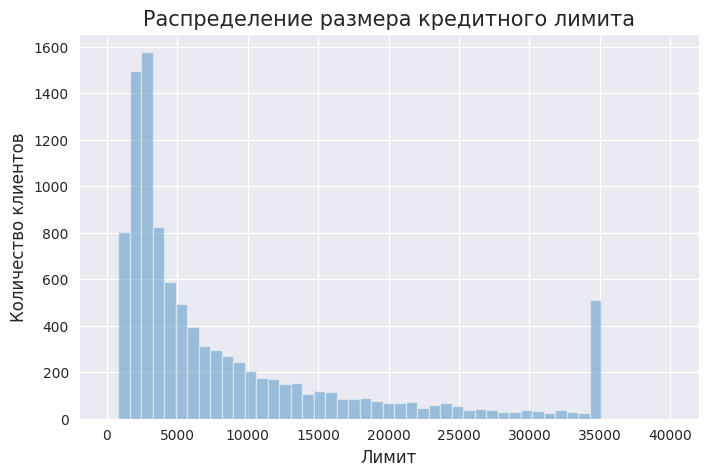

In [ ]:
plt.figure(figsize=(8, 5))
fig = sns.distplot(df['credit_limit'], kde=False, bins=np.linspace(start=0, stop=40000, num=50))
fig.set_title("Распределение размера кредитного лимита", fontsize=15)
fig.set_xlabel("Лимит", fontsize=12)
fig.set_ylabel("Количество клиентов", fontsize=12)

plt.show()

Распределение похоже на экспоненциальное, однако существует довольно большая группа клиентов, у которых, вероятно, одобрен максимально возможный лимит.

In [ ]:
df.groupby('attrition_flag')['credit_limit'].agg(['mean', 'std'])

mean          std
attrition_flag                          
0               8726.877518  9084.969807
1               8136.039459  9095.334105

Средний лимит выше в группе без оттока: 8726 долл. против 8136 долл.




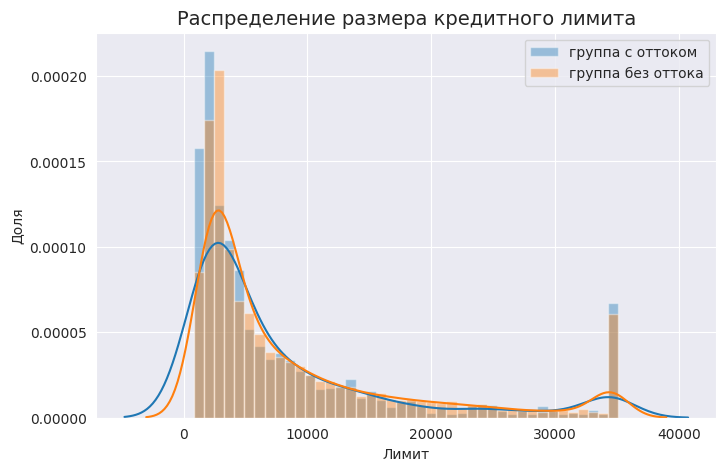

In [ ]:
plt.figure(figsize=(8, 5))
fig1 = sns.distplot(churn['credit_limit'], kde=True, bins=np.linspace(start=0, stop=40000, num=50), label='группа с оттоком')
fig2 = sns.distplot(nonchurn['credit_limit'], kde=True, bins=np.linspace(start=0, stop=40000, num=50), label='группа без оттока')
fig2.set_title("Распределение размера кредитного лимита", fontsize=14)
fig2.set_ylabel("Доля", fontsize=10)
fig2.set_xlabel("Лимит")
plt.legend()
plt.show()

Распределение в группе без оттока немного смещено направо относительно группы с оттоком, особенно сильно за счет многочисленных клиентов с небольшим лимитом. За счет этого больше и среднее значение.

**total_revolving_bal - размер остатка**

In [ ]:
df['total_revolving_bal'].describe()

count    10127.000000
mean      1162.814061
std        814.987335
min          0.000000
25%        359.000000
50%       1276.000000
75%       1784.000000
max       2517.000000
Name: total_revolving_bal, dtype: float64

Средний размер остатка - 1162 долл., медианный достаточно близок - 1276 долл. Границы - 0 и 2517 долл.

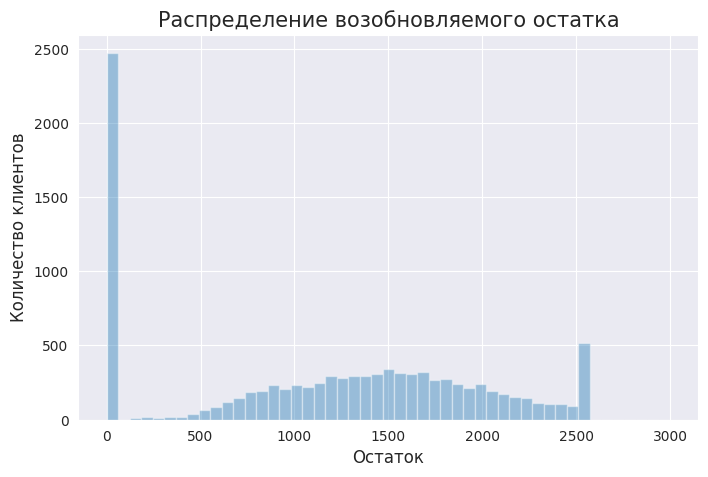

In [ ]:
plt.figure(figsize=(8, 5))
fig = sns.distplot(df['total_revolving_bal'], kde=False, bins=np.linspace(start=0, stop=3000, num=50))
fig.set_title("Распределение возобновляемого остатка", fontsize=15)
fig.set_xlabel("Остаток", fontsize=12)
fig.set_ylabel("Количество клиентов", fontsize=12)

plt.show()

In [ ]:
df.query('total_revolving_bal == 0').shape[0]

2470

В целом распределение визуально выглядит как нормальное, если отбросить 24% нулевых значений.

In [ ]:
df.groupby('attrition_flag')['total_revolving_bal'].agg(['mean', 'std'])

mean         std
attrition_flag                         
0               1256.604118  757.745354
1                672.822987  921.385582

Средний остаток почти вдвое выше в группе без оттока: 1256 долл. против 673 долл.

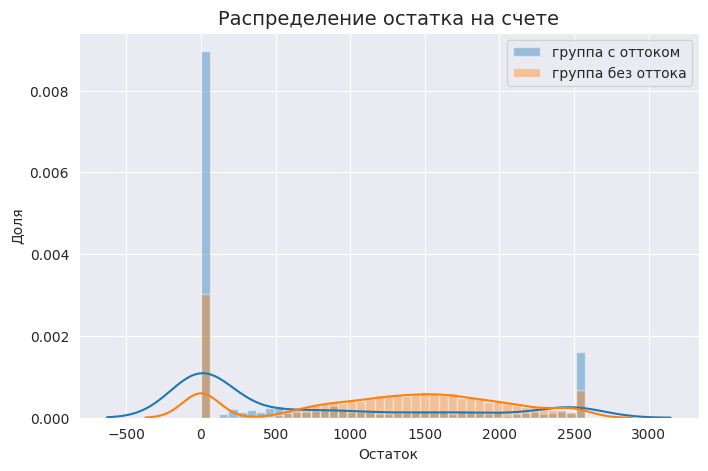

In [ ]:
plt.figure(figsize=(8, 5))
fig1 = sns.distplot(churn['total_revolving_bal'], kde=True, bins=np.linspace(start=0, stop=3000, num=50), label='группа с оттоком')
fig2 = sns.distplot(nonchurn['total_revolving_bal'], kde=True, bins=np.linspace(start=0, stop=3000, num=50), label='группа без оттока')
fig2.set_title("Распределение остатка на счете", fontsize=14)
fig2.set_ylabel("Доля", fontsize=10)
fig2.set_xlabel("Остаток")
plt.legend()
plt.show()

На графике хорошо видно, что остатки клиентов в группе с оттоком в основном либо нулевые, либо максимальные. В группе без оттока, во-первых, доля нулевых остатков ниже более чем в два раза, и, во-вторых, остальная часть значений плавно пробегает весь спектр.

**avg_open_to_buy - средняя за последние 12 месяцев разница между кредитным лимитом и текущим балансом**

In [ ]:
df['avg_open_to_buy'].describe()

count    10127.000000
mean      7469.139637
std       9090.685324
min          3.000000
25%       1324.500000
50%       3474.000000
75%       9859.000000
max      34516.000000
Name: avg_open_to_buy, dtype: float64

Средний размер показателя - 7469 долл., медиана - 3464 долл. Границы - 3 и 34516 долл.

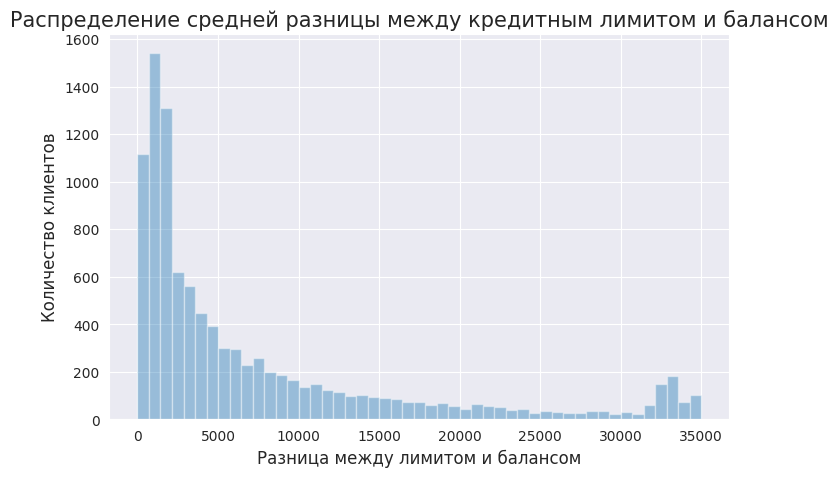

In [ ]:
plt.figure(figsize=(8, 5))
fig = sns.distplot(df['avg_open_to_buy'], kde=False, bins=np.linspace(start=0, stop=35000, num=50))
fig.set_title("Распределение средней разницы между кредитным лимитом и балансом", fontsize=15)
fig.set_xlabel("Разница между лимитом и балансом", fontsize=12)
fig.set_ylabel("Количество клиентов", fontsize=12)

plt.show()

Распределение визуально выглядит как экспоненциальное, не считая небольшого роста у максимальной границы.

In [ ]:
df.groupby('attrition_flag')['avg_open_to_buy'].agg(['mean', 'median', 'std'])

mean  median          std
attrition_flag                                  
0               7470.273400  3469.5  9087.671862
1               7463.216472  3488.0  9109.208129

И среднее значение, и медиана в обеих группах очень близки.

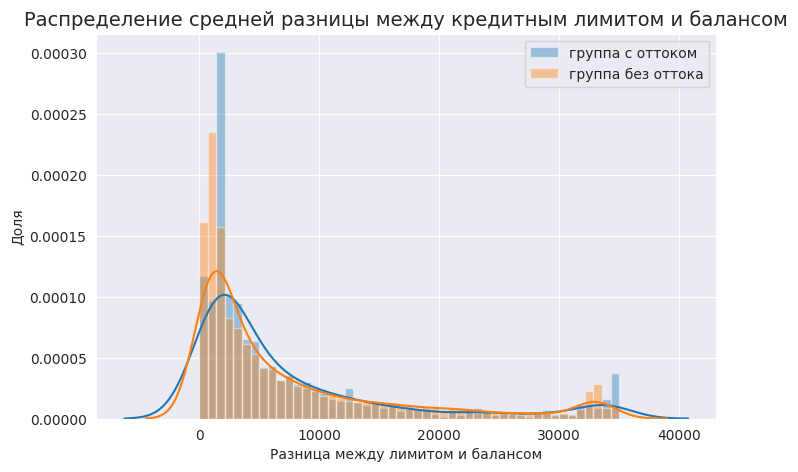

In [ ]:
plt.figure(figsize=(8, 5))
fig1 = sns.distplot(churn['avg_open_to_buy'], kde=True, bins=np.linspace(start=0, stop=35000, num=50), label='группа с оттоком')
fig2 = sns.distplot(nonchurn['avg_open_to_buy'], kde=True, bins=np.linspace(start=0, stop=35000, num=50), label='группа без оттока')
fig2.set_title("Распределение средней разницы между кредитным лимитом и балансом", fontsize=14)
fig2.set_ylabel("Доля", fontsize=10)
fig2.set_xlabel("Разница между лимитом и балансом")
plt.legend()
plt.show()

Распределение в группе с оттоком в начале графика лежит немного правее, чем в группе без оттока, что, тем не менее, практически не влияет на средние и дисперсию.

**total_amt_chng_q4_q1 - отношение суммы транзакций в 4-м квартала к сумме транзакций в 1-м**

In [ ]:
df['total_amt_chng_q4_q1'].describe()

count    10127.000000
mean         0.759941
std          0.219207
min          0.000000
25%          0.631000
50%          0.736000
75%          0.859000
max          3.397000
Name: total_amt_chng_q4_q1, dtype: float64

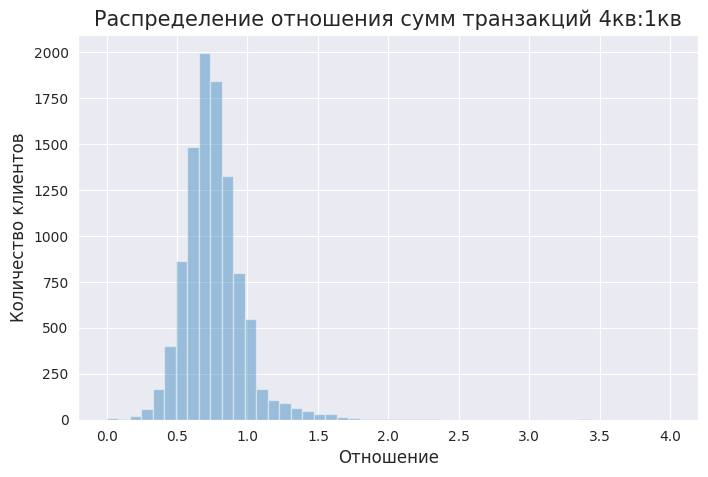

In [ ]:
plt.figure(figsize=(8, 5))
fig = sns.distplot(df['total_amt_chng_q4_q1'], kde=False, bins=np.linspace(start=0, stop=4, num=50))
fig.set_title("Распределение отношения сумм транзакций 4кв:1кв", fontsize=15)
fig.set_xlabel("Отношение", fontsize=12)
fig.set_ylabel("Количество клиентов", fontsize=12)

plt.show()

Как видно, основная часть распределения меньше 1.0, т.е траты клиентов снизились. Среднее значение показателя - 0,76., то есть сумма транзакций упала почти на четверть.

In [ ]:
df.groupby('attrition_flag')['total_amt_chng_q4_q1'].agg(['mean', 'median', 'std'])

mean  median       std
attrition_flag                            
0               0.772510   0.743  0.217783
1               0.694277   0.701  0.214924

И среднее, и медиана выше в группе без оттока, то есть траты этих клиентов снизились не так существенно.

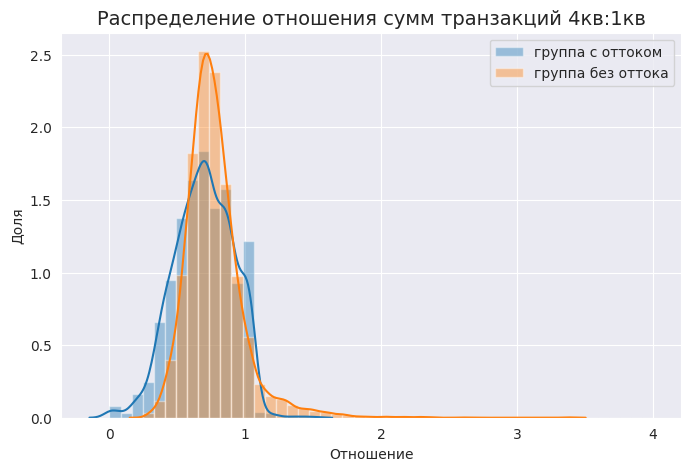

In [ ]:
plt.figure(figsize=(8, 5))
fig1 = sns.distplot(churn['total_amt_chng_q4_q1'], kde=True, bins=np.linspace(start=0, stop=4, num=50), label='группа с оттоком')
fig2 = sns.distplot(nonchurn['total_amt_chng_q4_q1'], kde=True, bins=np.linspace(start=0, stop=4, num=50), label='группа без оттока')
fig2.set_title("Распределение отношения сумм транзакций 4кв:1кв", fontsize=14)
fig2.set_ylabel("Доля", fontsize=10)
fig2.set_xlabel("Отношение")
plt.legend()
plt.show()

В группе без оттока "колокол" распределения уже, т.е. разброс от среднего меньше. Само среднее визуально не очень хорошо различимо, но оно уже подсчитано ранее и действительно превышает среднее в группе с оттоком.

**total_trans_amt - общая сумма транзакций за последние 12 месяцев**

In [ ]:
df['total_trans_amt'].describe()

count    10127.000000
mean      4404.086304
std       3397.129254
min        510.000000
25%       2155.500000
50%       3899.000000
75%       4741.000000
max      18484.000000
Name: total_trans_amt, dtype: float64

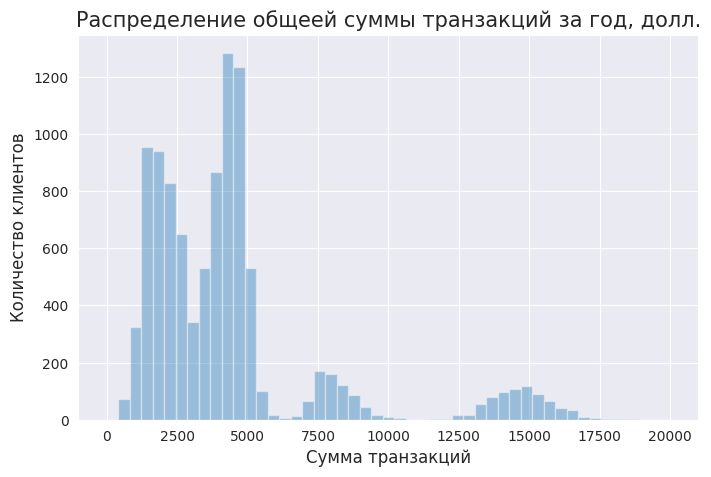

In [ ]:
plt.figure(figsize=(8, 5))
fig = sns.distplot(df['total_trans_amt'], kde=False, bins=np.linspace(start=0, stop=20000, num=50))
fig.set_title("Распределение общеей суммы транзакций за год, долл.", fontsize=15)
fig.set_xlabel("Сумма транзакций", fontsize=12)
fig.set_ylabel("Количество клиентов", fontsize=12)

plt.show()

У распределения сразу несколько мод - около 1800, 4500, 8000 и 15000 долл. Возможно, по этому признаку можно выделить сразу несколько групп клиентов.

In [ ]:
df.groupby('attrition_flag')['total_trans_amt'].agg(['mean', 'median', 'std'])

mean  median          std
attrition_flag                                  
0               4654.655882  4100.0  3512.772635
1               3095.025814  2329.0  2308.227629

И среднее, и медиана значительно выше в группе без оттока.

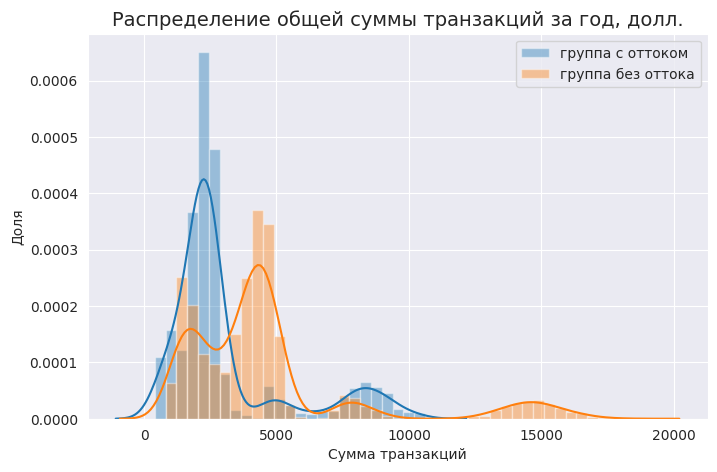

In [ ]:
plt.figure(figsize=(8, 5))
fig1 = sns.distplot(churn['total_trans_amt'], kde=True, bins=np.linspace(start=0, stop=20000, num=50), label='группа с оттоком')
fig2 = sns.distplot(nonchurn['total_trans_amt'], kde=True, bins=np.linspace(start=0, stop=20000, num=50), label='группа без оттока')
fig2.set_title("Распределение общей суммы транзакций за год, долл.", fontsize=14)
fig2.set_ylabel("Доля", fontsize=10)
fig2.set_xlabel("Сумма транзакций")
plt.legend()
plt.show()

В группе без оттока, во-первых, горздо менее явно проявлена первая подгруппа (с минимальной модой из четырех - на уровне 1500 долл.). Во-вторых, именно группа без оттока формирует вторую и четвертую подгруппы с модами 4500 и 15000 долл. суммарных транзакций.

**total_trans_ct общее число транзакций за последние 12 месяцев**

In [ ]:
df['total_trans_ct'].describe()

count    10127.000000
mean        64.858695
std         23.472570
min         10.000000
25%         45.000000
50%         67.000000
75%         81.000000
max        139.000000
Name: total_trans_ct, dtype: float64

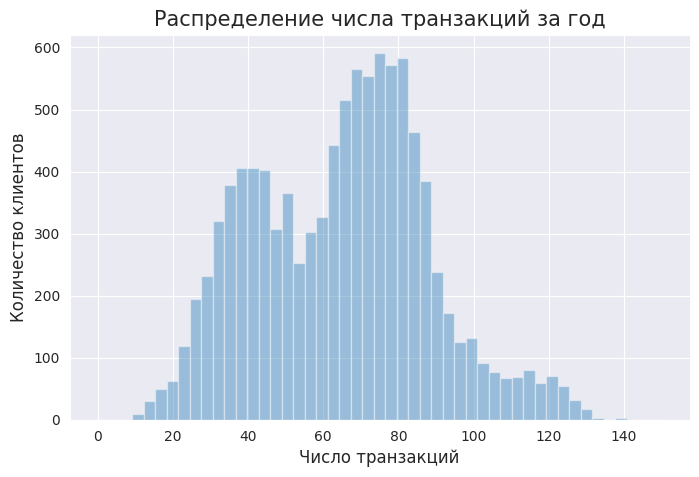

In [ ]:
plt.figure(figsize=(8, 5))
fig = sns.distplot(df['total_trans_ct'], kde=False, bins=np.linspace(start=0, stop=150, num=50))
fig.set_title("Распределение числа транзакций за год", fontsize=15)
fig.set_xlabel("Число транзакций", fontsize=12)
fig.set_ylabel("Количество клиентов", fontsize=12)

plt.show()

У распределения видим две моды - около 40 и 75 транзакций за год.

In [ ]:
df.groupby('attrition_flag')['total_trans_ct'].agg(['mean', 'median', 'std'])

mean  median        std
attrition_flag                              
0               68.672588    71.0  22.919011
1               44.933620    43.0  14.568429

И среднее, и медиана (и дисперсия) значительно выше в группе без оттока.

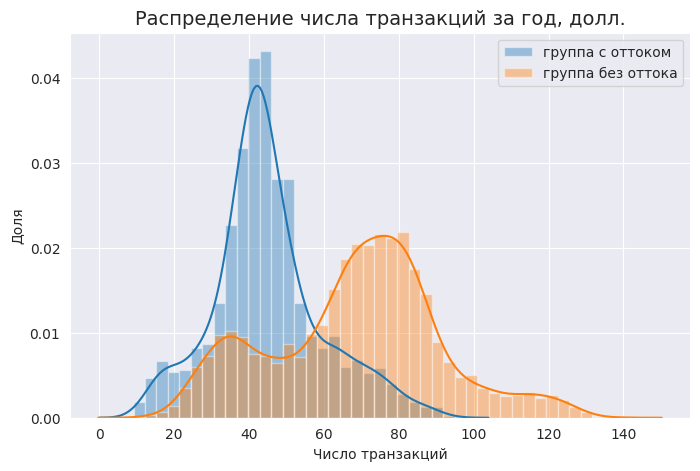

In [ ]:
plt.figure(figsize=(8, 5))
fig1 = sns.distplot(churn['total_trans_ct'], kde=True, bins=np.linspace(start=0, stop=150, num=50), label='группа с оттоком')
fig2 = sns.distplot(nonchurn['total_trans_ct'], kde=True, bins=np.linspace(start=0, stop=150, num=50), label='группа без оттока')
fig2.set_title("Распределение числа транзакций за год, долл.", fontsize=14)
fig2.set_ylabel("Доля", fontsize=10)
fig2.set_xlabel("Число транзакций")
plt.legend()
plt.show()

Наглядно видна разница распределений. На общем графике две моды, меньшая из которых получилась за счет среднего группы с оттоком, а большая - за счет группы без оттока.

**total_ct_chng_q4_q1 - отношение числа транзакций в 4-м квартала к числу транзакций в 1-м**

In [ ]:
df['total_ct_chng_q4_q1'].describe()

count    10127.000000
mean         0.712222
std          0.238086
min          0.000000
25%          0.582000
50%          0.702000
75%          0.818000
max          3.714000
Name: total_ct_chng_q4_q1, dtype: float64

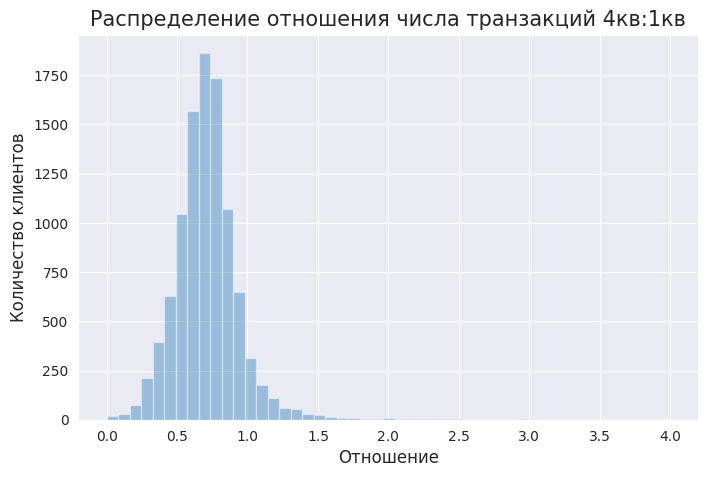

In [ ]:
plt.figure(figsize=(8, 5))
fig = sns.distplot(df['total_ct_chng_q4_q1'], kde=False, bins=np.linspace(start=0, stop=4, num=50))
fig.set_title("Распределение отношения числа транзакций 4кв:1кв", fontsize=15)
fig.set_xlabel("Отношение", fontsize=12)
fig.set_ylabel("Количество клиентов", fontsize=12)

plt.show()

И вновь основная часть распределения меньше 1.0, т.е число транзакций клиентов тоже снизились. Среднее значение показателя - 0,71.

In [ ]:
df.groupby('attrition_flag')['total_ct_chng_q4_q1'].agg(['mean', 'median', 'std'])

mean  median       std
attrition_flag                            
0               0.742434   0.721  0.228054
1               0.554386   0.531  0.226854

И среднее, и медиана существенно выше в группе без оттока, то есть частота трат этих клиентов снизились не так значительно.

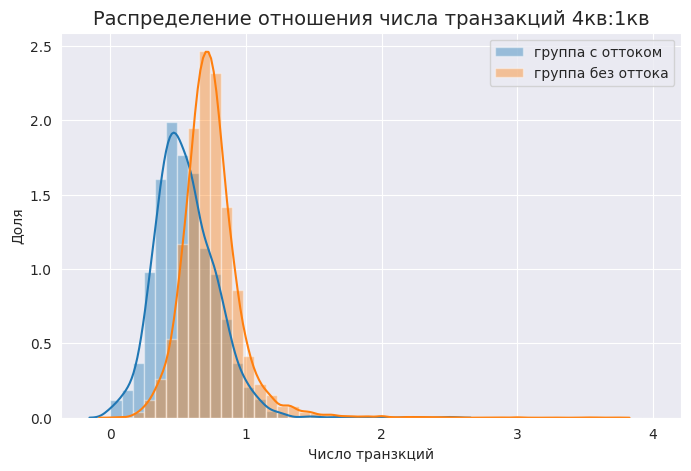

In [ ]:
plt.figure(figsize=(8, 5))
fig1 = sns.distplot(churn['total_ct_chng_q4_q1'], kde=True, bins=np.linspace(start=0, stop=4, num=50), label='группа с оттоком')
fig2 = sns.distplot(nonchurn['total_ct_chng_q4_q1'], kde=True, bins=np.linspace(start=0, stop=4, num=50), label='группа без оттока')
fig2.set_title("Распределение отношения числа транзакций 4кв:1кв", fontsize=14)
fig2.set_ylabel("Доля", fontsize=10)
fig2.set_xlabel("Число транзкций")
plt.legend()
plt.show()

Распределение группы без оттока сдвинуто вправо относительно распределения в группе с оттоком.

**avg_utilization_ratio - средний коэффициент использования лимита**

In [ ]:
df['avg_utilization_ratio'].describe()

count    10127.000000
mean         0.274894
std          0.275691
min          0.000000
25%          0.023000
50%          0.176000
75%          0.503000
max          0.999000
Name: avg_utilization_ratio, dtype: float64

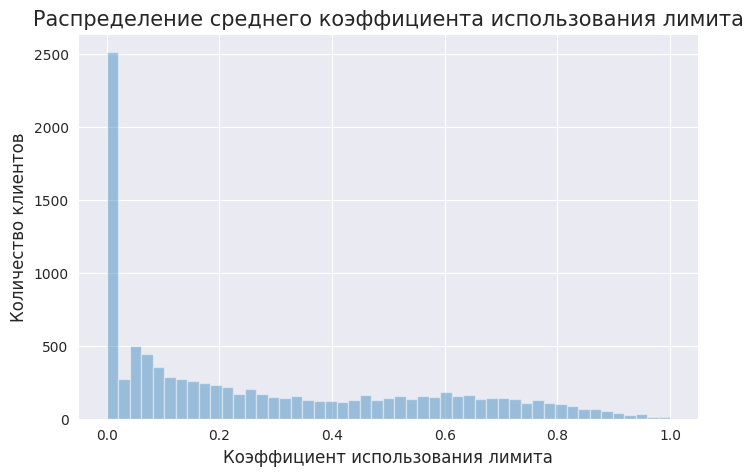

In [ ]:
plt.figure(figsize=(8, 5))
fig = sns.distplot(df['avg_utilization_ratio'], kde=False, bins=np.linspace(start=0, stop=1, num=50))
fig.set_title("Распределение среднего коэффициента использования лимита", fontsize=15)
fig.set_xlabel("Коэффициент использования лимита", fontsize=12)
fig.set_ylabel("Количество клиентов", fontsize=12)

plt.show()

Большая часть клиентов использует минимальную долю лимита. Первый квартиль составляет всего 2,3%, медиана - 17,6%. И только згначение третьего квартиля - 50% лимита.

In [ ]:
df.groupby('attrition_flag')['avg_utilization_ratio'].agg(['mean', 'median', 'std'])

mean  median       std
attrition_flag                            
0               0.296412   0.211  0.272568
1               0.162475   0.000  0.264458

Среднее существенно выше в группе без оттока (33% против 16%), т.е. такие клиенты больше используют лимит. Медиана в группе с оттоком вообще составляет 0, что значит, что как минимум половина не пользуется кредитной картой вообще.

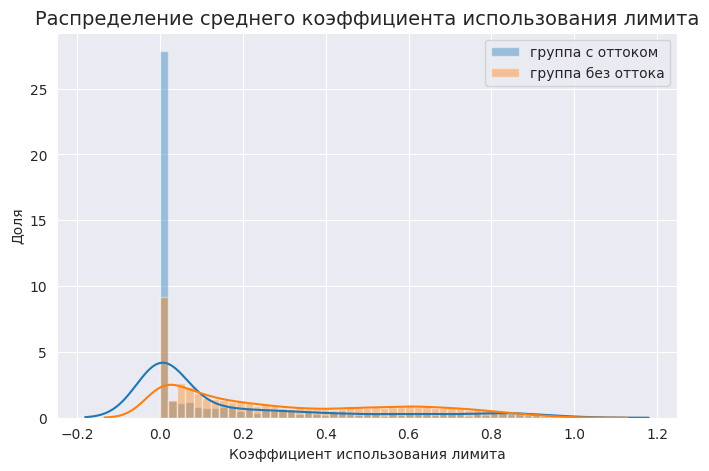

In [ ]:
plt.figure(figsize=(8, 5))
fig1 = sns.distplot(churn['avg_utilization_ratio'], kde=True, bins=np.linspace(start=0, stop=1, num=50), label='группа с оттоком')
fig2 = sns.distplot(nonchurn['avg_utilization_ratio'], kde=True, bins=np.linspace(start=0, stop=1, num=50), label='группа без оттока')
fig2.set_title("Распределение среднего коэффициента использования лимита", fontsize=14)
fig2.set_ylabel("Доля", fontsize=10)
fig2.set_xlabel("Коэффициент использования лимита")
plt.legend()
plt.show()

График подтверждает выводы выше.

#### **Проверка статистических гипотез о разницах между группами**

С помощью статистических тестов проверим несколько гипотез об отличиях признаков в группе с оттоком и без оттока.

На ряде графиков отличия между распределениями очевидны (например, число и сумма транзакций, размер остатка). На других разница выглядит не столь значительно и может быть обусловлена случайностями. Проверим гипотезы о равенстве/неравенстве средних значений для показателей возраста, продолжительности обслуживания в банке, а также кредитного лимита.

**Возраст клиента**

**Нулевая гипотеза**: "Средний возраст у клиентов из группы с оттоком и без оттока одинаков".

**Альтернативная гипотеза**: "Средний возраст у клиентов из группы с оттоком и без оттока одинаковы различается".

В качестве критического уровеня статистической значимости возьмем стандартное значение **0.05**.

Обозначим сравниваемые выборки:

In [ ]:
age_c = churn['customer_age']
age_nc = nonchurn['customer_age']

В качестве статистического критерия применим тест Стьюдента. Критерий использовать допустимо, так как объем выборок достаточно велик, следовательно, соблюдается ЦПТ и требование о нормальности выборочных средних удовлетворяется. Выбросы в распределении отсутствуют.

Перед тестом проверим равенство дисперсий тестом Левена:

In [ ]:
result_levene = st.levene(age_c, age_nc, center='mean')
print('p-значение:', result_levene.pvalue.round(5))

p-значение: 0.01575


p-значение теста Левена выше критического уровеня значимости, поэтому нет оснований отвергнуть нулевую гипотезу о равенстве дисперсий выборок по возрасту.

In [ ]:
result_age = st.ttest_ind(age_c, age_nc, equal_var=True)
print('p-значение:', result_age.pvalue.round(5))

p-значение: 0.06699


p-значение теста Сьюдента выше критического уровеня значимости, поэтому нет оснований отвергнуть нулевую гипотезу о равенстве среднего возраста для клиентов из группы с оттоком и без.

**Срок обслуживания в банке**

**Нулевая гипотеза**: "Средний срок обслуживания в банке у клиентов из группы с оттоком и без оттока одинаков".

**Альтернативная гипотеза**: "Средний срок обслуживания в банке у клиентов из группы с оттоком и без оттока одинаковы различается".

In [ ]:
month_c = churn['months_on_book']
month_nc = nonchurn['months_on_book']

В распределениях содержатся выбросы, поэтому вместо теста Стьюдента воспользуемся непараметрическим тестом Уилкоксона-Манна-Уитни.

In [ ]:
result_test = st.mannwhitneyu(month_c, month_nc, True, 'two-sided')
print('p-значение: ', result_test.pvalue.round(5))

p-значение:  0.12367


Результат теста говорит о том, что оснований отвергнуть нулевую гипотезу нет, соответственно, нельзя сделать вывод о различии групп по признаку срока обслуживания в банке.

**Кредитный лимит**

**Нулевая гипотеза**: "Среднее значение кредитного лимита у клиентов из группы с оттоком и без оттока одинаково".

**Альтернативная гипотеза**: "Среднее значение кредитного лимита у клиентов из группы с оттоком и без оттока одинаково".

In [ ]:
lim_c = churn['credit_limit']
lim_nc = nonchurn['credit_limit']

И вновь в распределениях содержатся выбросы, поэтому воспользуемся тестом Уилкоксона-Манна-Уитни.

In [ ]:
result_test = st.mannwhitneyu(lim_c, lim_nc, True, 'two-sided')
print('p-значение: ', result_test.pvalue.round(5))

p-значение:  0.0


p-value меньше выбранного уровня значимости, поэтому есть основание отвергнуть нулевую гипотезу в пользу альтернативной, и кредитные лимиты для клиентов из групп с оттоком и без различны.

#### **Вывод**

Проведен предварительный анализ данных:

- в датасете содержится 21 признак для 10127 клиентов банка;
- дубликаты и пропуски отсутствуют;
- проведен исследовательский анализ каждого признака в разрезе целевой переменной (отток):
    - группа клиентов в оттоке составляет 16% от всей выборки;
    - сильнее всего группы отличаются друг от друга по признакам, харакеризующим активность клиента в банке вообще и по кредитному лимиту в частности:
      - размер лимита (среднее 8726 долл. в группе без оттока, 8136 долл. - в группе с оттоком), различие статистически значимо;
      - размер остатка на счете (среднее 1256 долл. в группе без оттока, 672 долл. - в группе с оттоком);
      - число продуктов (среднее 3,91 в группе без оттока, 3,27 - в группе с оттоком);
      - количеству неактивных месяцев (среднее 2,3 в группе без оттока, 2,7 - в группе с оттоком);
      - коэффициент использования лимита (среднее 0,29 в группе без оттока, 0,16 - в группе с оттоком);
      - общая сумма и число транзакций за последний год (среднее 4654 долл. и 68 шт. в группе без оттока, 3095 долл. и 44 шт. - в группе с оттоком);
      - отношение суммы и числа транзакций в 4 квартале к первому кварталу (среднее 0,77 и 0,74 соответственно в группе без оттока, 0,69 и 0,55 соответственно - в группе с оттоком);
    - менее явная связь с годовым доходом, семейным положением, полом клиента;
    - отсутствует связь со следующими признаками: возраст, число иждивенцев, уровень образования, тип кредитной карты, срок нахождения в статусе клиента, разница между размером лимита и балансом счета.


  

### Кодирование переменных

In [ ]:
df.head()

clientnum attrition_flag  customer_age gender  dependent_count  \
0  768805383              0            45      M                3   
1  818770008              0            49      F                5   
2  713982108              0            51      M                3   
3  769911858              0            40      F                4   
4  709106358              0            40      M                3   

  education_level marital_status income_category card_category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   months_on_book  total_relationship_count  months_inactive_12_mon  \
0              39                         5                       1   
1              44                         6                       1   
2              36                         4                       1   
3              34                         3                       4   
4              21                         5                       1   

   contacts_count_12_mon  credit_limit  total_revolving_bal  avg_open_to_buy  \
0                      3       12691.0                  777          11914.0   
1                      2        8256.0                  864           7392.0   
2                      0        3418.0                    0           3418.0   
3                      1        3313.0                 2517            796.0   
4                      0        4716.0                    0           4716.0   

   total_amt_chng_q4_q1  total_trans_amt  total_trans_ct  total_ct_chng_q4_q1  \
0                 1.335             1144              42                1.625   
1                 1.541             1291              33                3.714   
2                 2.594             1887              20                2.333   
3                 1.405             1171              20                2.333   
4                 2.175              816              28                2.500   

   avg_utilization_ratio  
0                  0.061  
1                  0.105  
2                  0.000  
3                  0.760  
4                  0.000

В датасете достаточно большое количество категориальных признаков. Чтобы в дальнейшем иметь возможность обучить модель, предпочтительно перевести текстовые значения в числовые. Для этого воспользуемся прямым кодированием.

Чтобы избавиться от линейной зависимости получившихся столбцов, удалим по одной колонке с помощью параметра drop_first:

In [ ]:
df_mod = df.copy()

In [ ]:
df_mod = pd.get_dummies(df_mod,
                        columns=['gender', 'education_level', 'marital_status', 'income_category', 'card_category'], drop_first=True, dtype=int)

In [ ]:
df_mod.columns = df_mod.columns.str.lower()
df_mod.head()

clientnum attrition_flag  customer_age  dependent_count  months_on_book  \
0  768805383              0            45                3              39   
1  818770008              0            49                5              44   
2  713982108              0            51                3              36   
3  769911858              0            40                4              34   
4  709106358              0            40                3              21   

   total_relationship_count  months_inactive_12_mon  contacts_count_12_mon  \
0                         5                       1                      3   
1                         6                       1                      2   
2                         4                       1                      0   
3                         3                       4                      1   
4                         5                       1                      0   

   credit_limit  total_revolving_bal  avg_open_to_buy  total_amt_chng_q4_q1  \
0       12691.0                  777          11914.0                 1.335   
1        8256.0                  864           7392.0                 1.541   
2        3418.0                    0           3418.0                 2.594   
3        3313.0                 2517            796.0                 1.405   
4        4716.0                    0           4716.0                 2.175   

   total_trans_amt  total_trans_ct  total_ct_chng_q4_q1  \
0             1144              42                1.625   
1             1291              33                3.714   
2             1887              20                2.333   
3             1171              20                2.333   
4              816              28                2.500   

   avg_utilization_ratio  gender_m  education_level_doctorate  \
0                  0.061         1                          0   
1                  0.105         0                          0   
2                  0.000         1                          0   
3                  0.760         0                          0   
4                  0.000         1                          0   

   education_level_graduate  education_level_high school  \
0                         0                            1   
1                         1                            0   
2                         1                            0   
3                         0                            1   
4                         0                            0   

   education_level_post-graduate  education_level_uneducated  \
0                              0                           0   
1                              0                           0   
2                              0                           0   
3                              0                           0   
4                              0                           1   

   education_level_unknown  marital_status_married  marital_status_single  \
0                        0                       1                      0   
1                        0                       0                      1   
2                        0                       1                      0   
3                        0                       0                      0   
4                        0                       1                      0   

   marital_status_unknown  income_category_$40k - $60k  \
0                       0                            0   
1                       0                            0   
2                       0                            0   
3                       1                            0   
4                       0                            0   

   income_category_$60k - $80k  income_category_$80k - $120k  \
0                            1                             0   
1                            0                             0   
2                            0                             1   
3                            0

Теперь все признаки представлены в числовом формате.

### Удаление столбцов

Удалим столбец с уникальным номером клиента, так как он не несет смысловой нагрузки для предсказания оттока.

In [ ]:
df_mod = df_mod.drop(['clientnum'], axis=1)

### Корреляция признаков

Проверим, есть ли среди признаков коллинеарные. Если таковые найдутся, возможно, будет иметь смысл исключить их из датасета, чтобы не утяжелять модель.


Так как стандартная матрица корреляции подходит для оценки только количественных переменных, возьмем соответствующую часть датафрейма:

In [ ]:
df_mod_num = df[['customer_age', 'dependent_count', 'months_on_book', 'total_relationship_count', 'months_inactive_12_mon', 'contacts_count_12_mon',\
                 'credit_limit', 'total_revolving_bal', 'avg_open_to_buy', 'total_amt_chng_q4_q1', 'total_trans_amt', 'total_trans_ct',\
                 'total_ct_chng_q4_q1', 'avg_utilization_ratio']]
feat_mod_num = ['возраст', 'число иждивенцев', 'срок статуса "клиент"', 'количество продуктов банка', 'число неактивных месяцев', 'количество контактов с клиентом',\
                 'размер кредитного лимита', 'размер возобновляемого остатка', 'разница между лимитом и балансом', 'разница в сумме транзакций 4кв:1кв',\
                 'общая сумма транзакций', 'общее число транзакций', 'разница в числе транзакций 4кв:1кв', 'коэффициент использования лимита']
cmn = df_mod_num.corr()

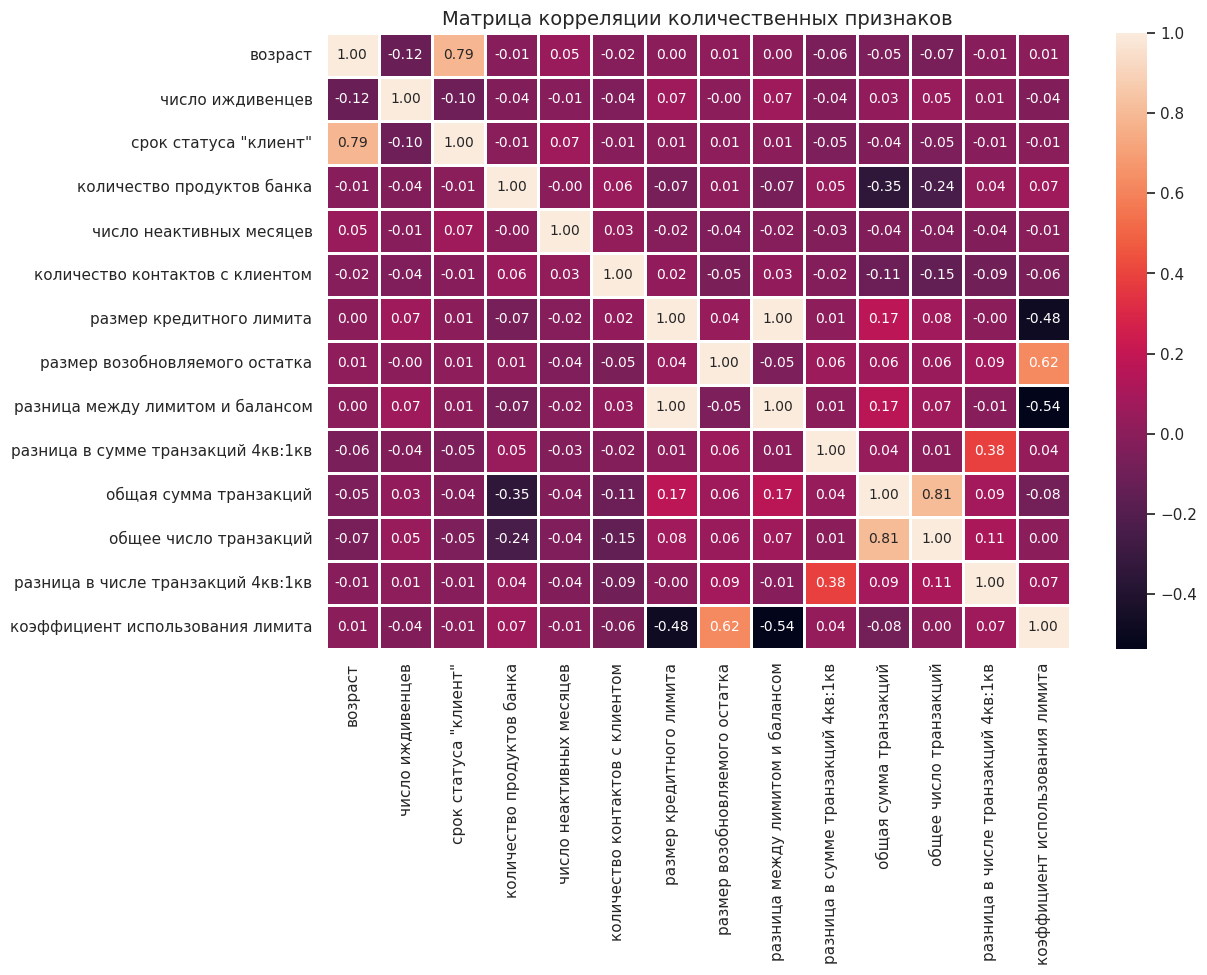

In [ ]:
sns.set(style = 'white')
plt.figure(figsize = (12, 8))
plt.title('Матрица корреляции количественных признаков', fontsize=14)
ax = sns.heatmap(cmn, annot=True, linewidths=1, linecolor='white', fmt='.2f', annot_kws={"size":10},\
                 xticklabels=feat_mod_num, yticklabels=feat_mod_num)
plt.xticks(rotation = 90)
plt.show()

Посторим также парные графики в разрезе целевой переменной. Дискретные переменные с небольшим количеством значений не так наглядны, поэтому оставим только непрерывные:

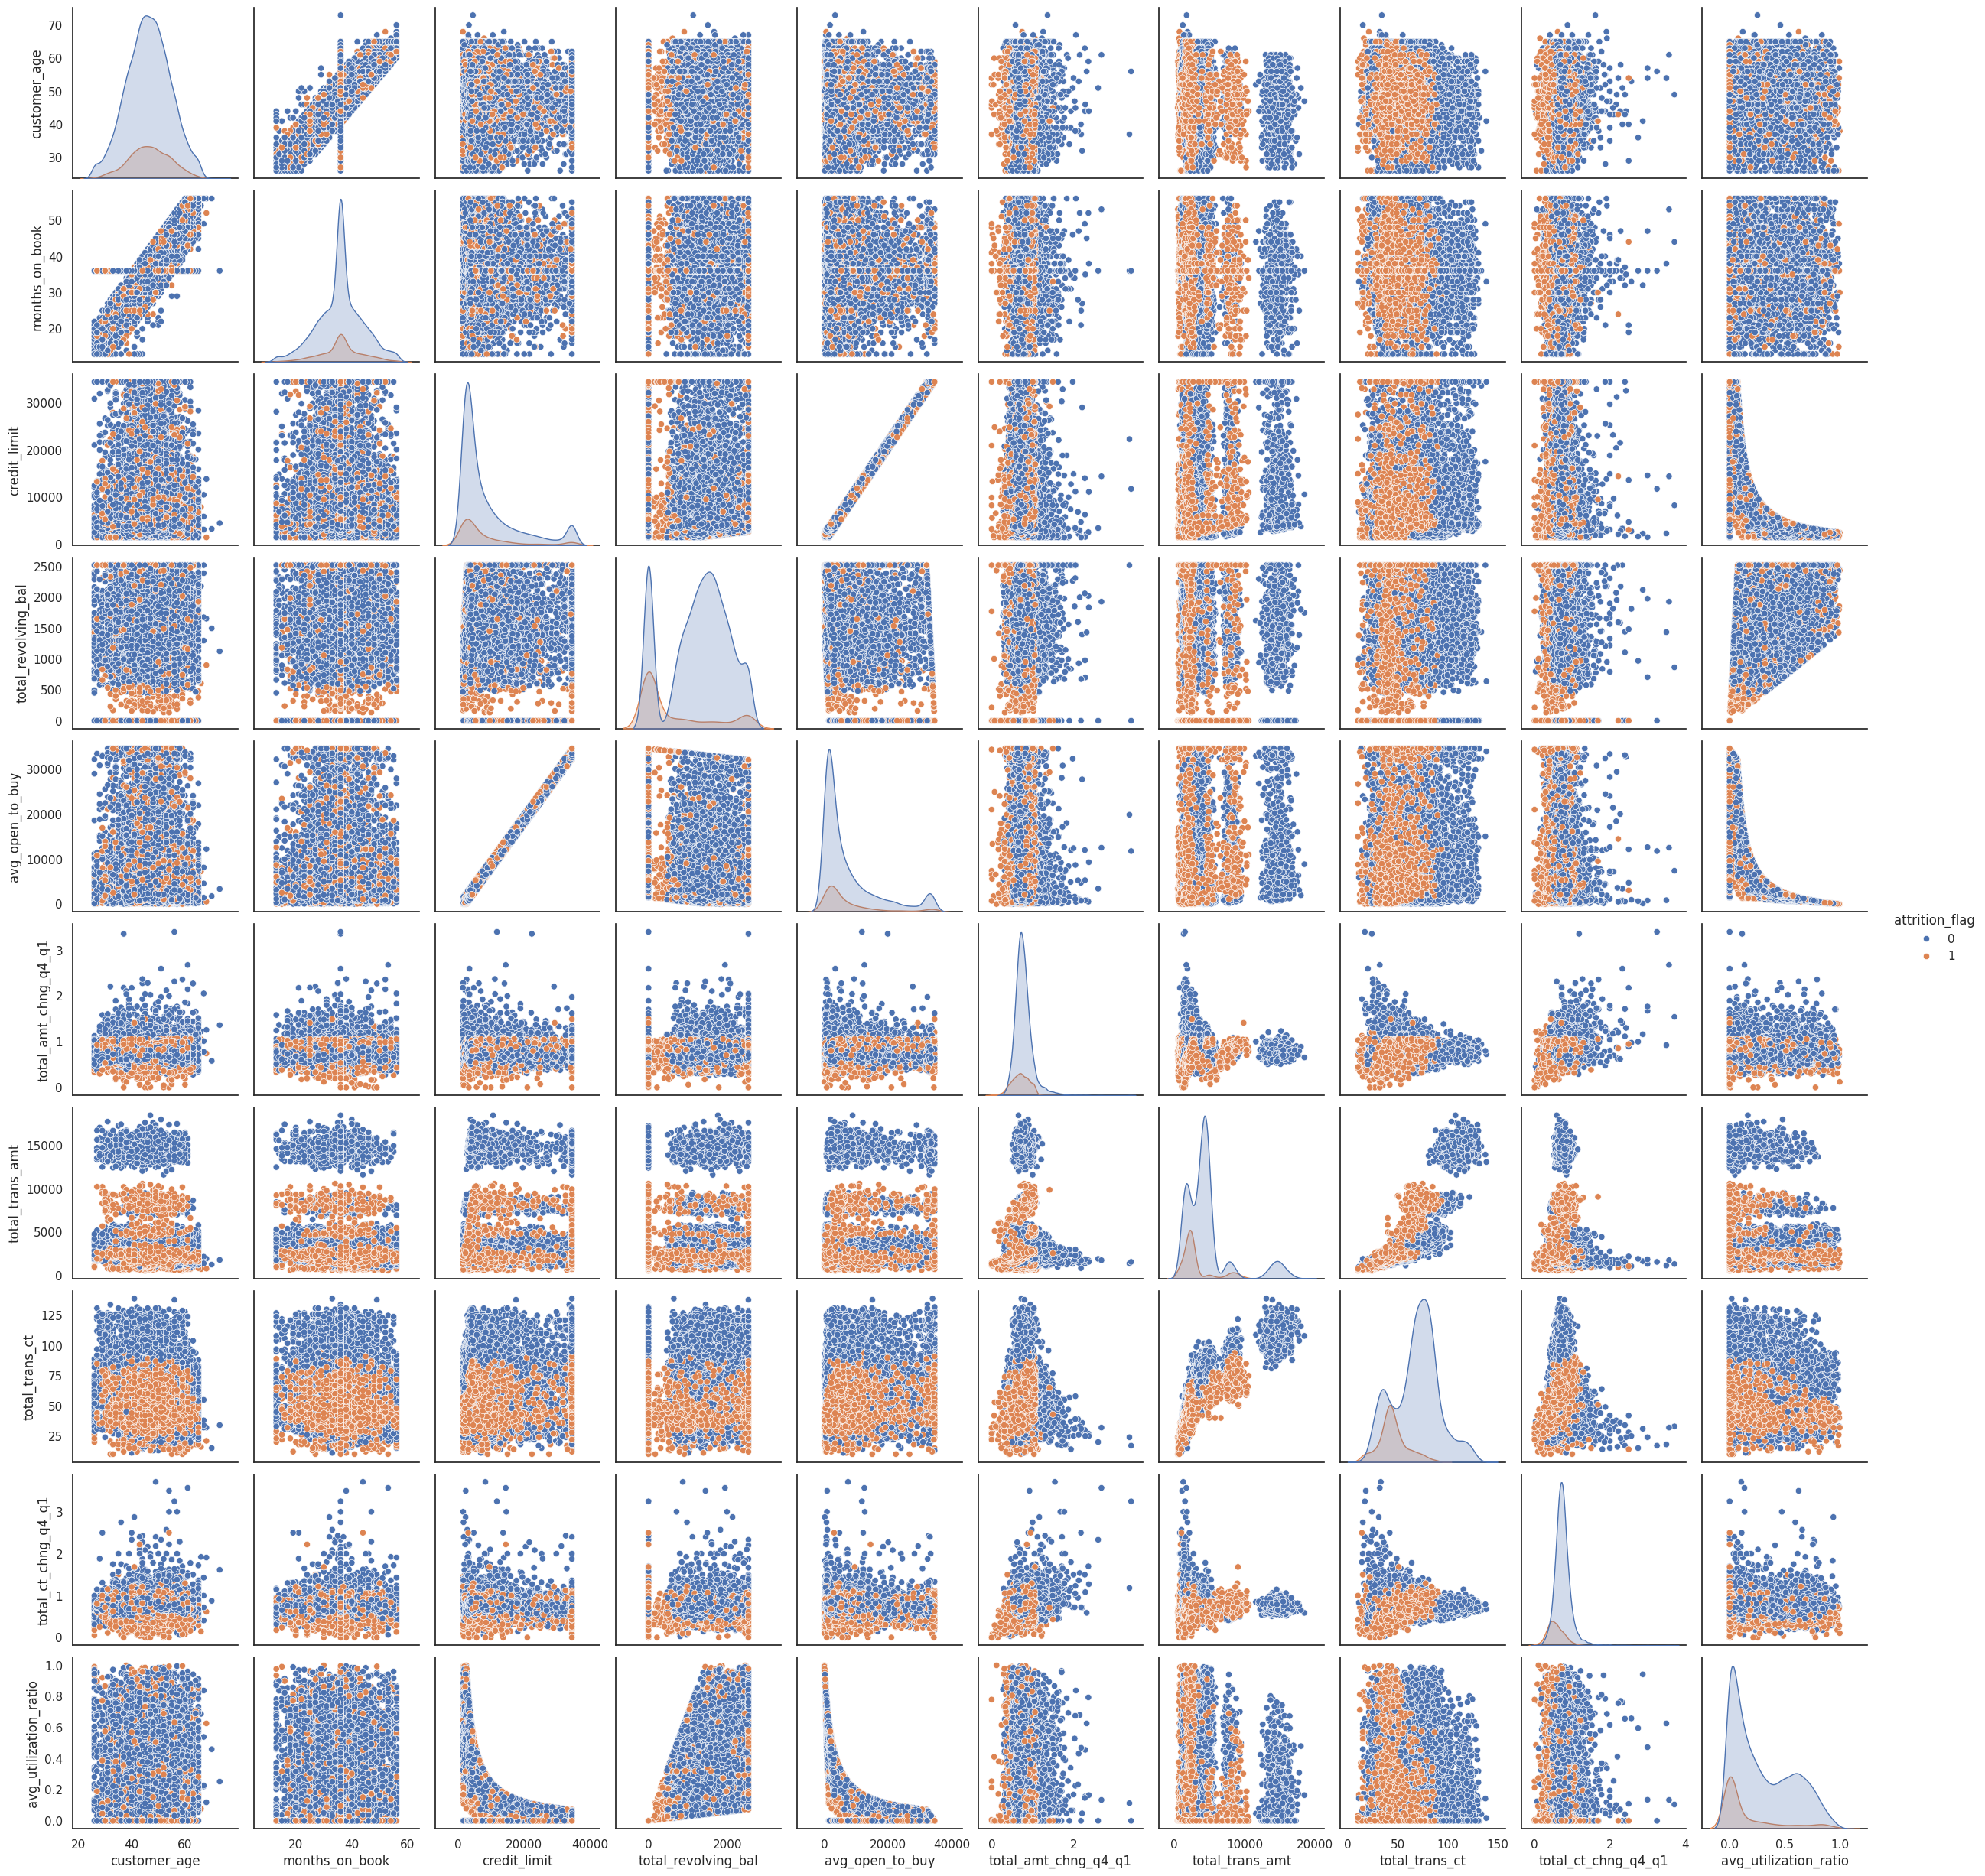

In [ ]:
df_mod_cont = df[['customer_age', 'months_on_book', 'credit_limit', 'total_revolving_bal', 'avg_open_to_buy', 'total_amt_chng_q4_q1',\
                  'total_trans_amt', 'total_trans_ct', 'total_ct_chng_q4_q1', 'avg_utilization_ratio', 'attrition_flag']]
sns.pairplot(df_mod_cont, height = 2.5, hue = 'attrition_flag')
plt.show()

Матрица корреляции показывает достаточно высокую связь между возрастом клиента и сроком его обслуживания в банке (коэффициент корреляции 0,79), между суммой и числом транзакций (0,81), размером лимита и разницей между лимитом и балансом (1), коэффициентом использования лимита и размером лимита (-0,48), размером возобновляемого остатка (0,62) и разницей между лимитом и балансом (-0,54).

Для оценки взаимосвязи между категориальными переменными воспользуаемся коэффициентом Спирмена, а не Пирсона, который встроен по умолчанию:

In [ ]:
df_mod_cat = df_mod.drop(['customer_age', 'dependent_count', 'months_on_book', 'total_relationship_count', 'months_inactive_12_mon', 'contacts_count_12_mon',\
                 'credit_limit', 'total_revolving_bal', 'avg_open_to_buy', 'total_amt_chng_q4_q1', 'total_trans_amt', 'total_trans_ct',\
                 'total_ct_chng_q4_q1', 'avg_utilization_ratio'], axis = 1)
feat_mod_cat = ['отток', 'мужской пол', 'доктор наук', 'высшее образование', 'старшая школа', 'аспирантура',\
                 'нет образования', 'уровень образования неизвестен', 'женат', 'не женат',\
                 'семейное положение неизвестно', 'доход 40-60 тыс. долл.', 'доход 60-80 тыс. долл.', 'доход 80-120 тыс. долл.',\
                 'доход менее 40 тыс. долл.', 'доход неизвестен', 'золотая карта', 'платиновая карта', 'серебряная карта']

In [ ]:
cmn_cat = df_mod_cat.corr(method='spearman')

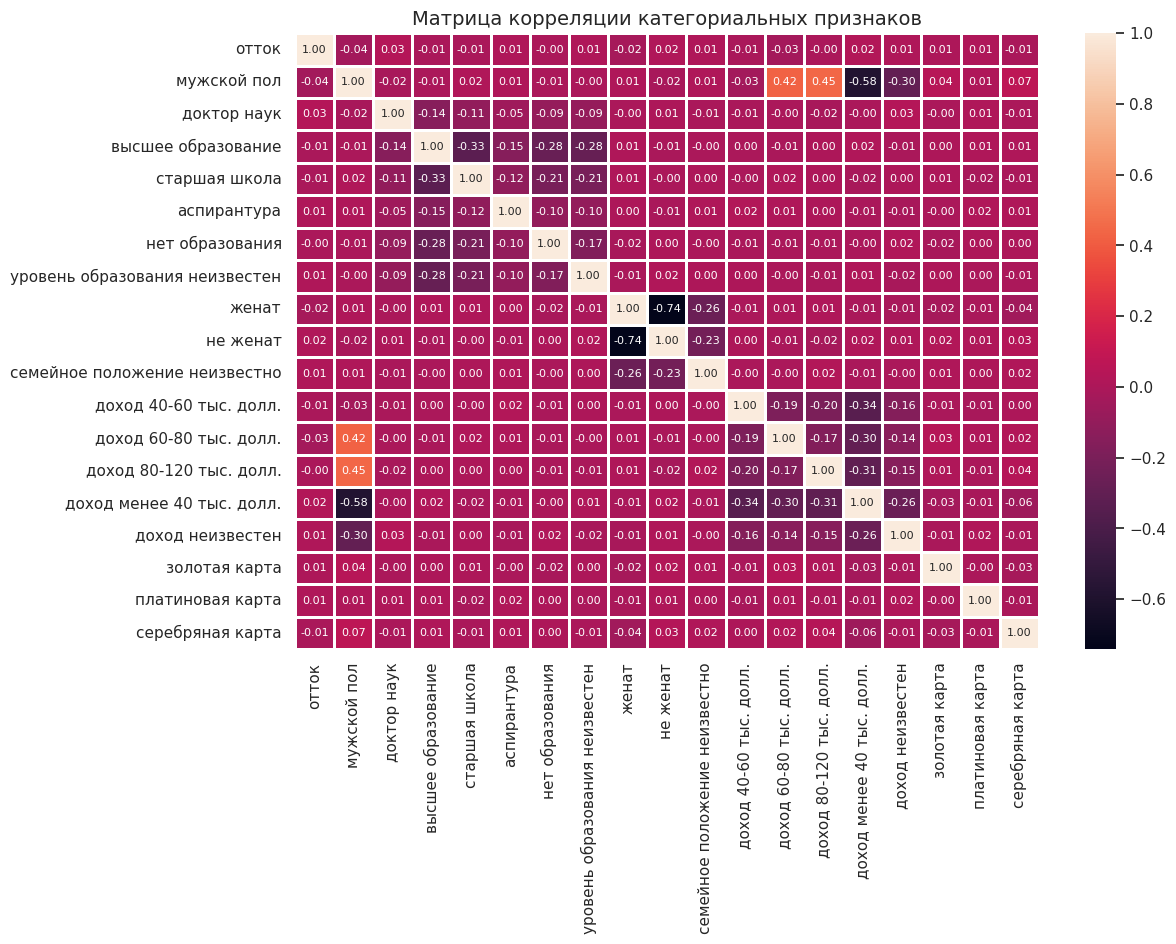

In [ ]:
sns.set(style = 'white')
plt.figure(figsize = (12, 8))
plt.title('Матрица корреляции категориальных признаков', fontsize=14)
ax = sns.heatmap(cmn_cat, annot=True, linewidths=1, linecolor='white', fmt='.2f', annot_kws={"size":8},\
                 xticklabels=feat_mod_cat, yticklabels=feat_mod_cat)
plt.xticks(rotation = 90)
plt.show()

Корреляция ожидаемо обнаруживается между переменными, созданными с помощью кодирования из одного и того же признака. Также видим зависимость между уровнем зарплаты и полом (у мужчин выше).

### Разбивка данных на выборки

Целевой признак в рассматриваемой задаче - это показатель оттока:

In [ ]:
target = df_mod['attrition_flag']
features = df_mod.drop('attrition_flag', axis=1)

Разделим данные на обучающую и тестовую выборки в пропорции 80:20 соответственно:

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [ ]:
display(features_train.shape, target_train.shape[0])
display(features_test.shape, target_test.shape[0])

(8101, 32)

8101

(2026, 32)

2026

In [ ]:
target_train = target_train.astype('int')
target_test = target_test.astype('int')

### Масштабирование признаков

Рассматриваемые переменные имеют разный масштаб. Чтобы модель корректно проводила оценку параметров, настроим стандартизацию количественных признаков на обучающей выборке и преобразуем обе выборки:

In [ ]:
numeric = ['customer_age', 'dependent_count', 'months_on_book', 'total_relationship_count', 'months_inactive_12_mon', 'contacts_count_12_mon',\
           'credit_limit', 'total_revolving_bal', 'avg_open_to_buy', 'total_amt_chng_q4_q1', 'total_trans_amt', 'total_trans_ct',\
           'total_ct_chng_q4_q1', 'avg_utilization_ratio']

In [ ]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

### Вывод

Проведены предварительный анализ и подготовка данных:

- проведен исследовательский анализ каждого признака в разрезе целевой переменной (см. подраздел "Вывод" параграфа "Анализ признаков");
- признаки закодированы;
- удален столбец **clientnum**, не требующийся для дальнейшего анализа;
- рассчитаны коэффициенты корреляции между переменными.
- данные разбиты на обучающую и тестовую выборки в пропорции 80:20;
- небинарные признаки масштабированы.

## Обучение моделей

Будем сравнивать работу следующих моделей:

- логистической регрессии;
- дерева решений;
- случайного леса;
- CatBoost;
- LightGBM.

Функция для поиска оптимального набора гиперпараметров моделей по метрике ROC-AUC (внутри применяется GridSearchCV, поэтому валидационную выборку отдельно не используем):

In [ ]:
def grid_search(model, params, features, target):

    auc_roc = make_scorer(roc_auc_score, greater_is_better=True)
    g_search = GridSearchCV(model, params, scoring=auc_roc, n_jobs=-1)
    g_search.fit(features, target)

    print('Лучший набор гиперпараметров:', g_search.best_params_)
    print('Качество предсказания:', round(g_search.best_score_, 5))
    print('Лучшая модель:', g_search.best_estimator_)
    return g_search.best_estimator_

Функция для оценки качества результатов работы модели:

In [ ]:
# обучает модель на тренировочной выборке и оценивает качество метрикой ROC-AUC на тестовой, результаты записывает в таблицу
# дополнительно считает accuracy, F1, precision и recall

def model_result(model, features_train, features_test, target_train, target_test, df_result):

    model.fit(features_train, target_train)
    predicted = model.predict(features_test)
    probabilities_test = model.predict_proba(features_test)
    probabilities_one_test = probabilities_test[:, 1]

    auc_roc = roc_auc_score(target_test, probabilities_one_test).round(5)
    accuracy = accuracy_score(target_test, predicted).round(5)
    f1 = f1_score(target_test, predicted).round(5)
    precision = precision_score(target_test, predicted).round(5)
    recall = recall_score(target_test, predicted).round(5)

    df_result.append({'model': model.__class__.__name__, 'ROC-AUC': auc_roc, 'Accuracy': accuracy, 'F1': f1,
                     'Precision': precision, 'Recall': recall,})

Обучим несколько разных моделей на тренировочных выборкахи оценим их качество на тестовой. Записывать результаты будем в отдельную таблицу.

В качестве основных метрик выберем ROC-AUC, F1 и recall (полноту), поскольку стоимость привлечения нового клиента для банка, как правило, значительно выше, чем удержание текущего. Для модели важно не упустить максимальное количество клиентов, которые могут попасть в оттток.
При этом стоит иметь в виду, что при проведении маркетинговых кампаний бюджет ограничен, и высокое значение precision (точности) позволит экономить средства, не затрачивая их на клиентов, которых модель ошибочно отметит как отточных, но которые при этом не собираются уходить.

Поскольку наблюдается существенный дисбаланс классов, accuracy представляет для нас меньший интерес по сравнению с остальными метриками.

In [ ]:
result = []

### Логистическая регрессия

В качестве гиперпараметра выберем значение обратной регуляризации. Так как в выборке наблюдается дисбалансе классов, воспользуемся параметром class_weight:

In [ ]:
lr_model = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced')
lr_params = {'C': np.arange(0.1, 5, 0.1)}

In [ ]:
%%time
lr_best = grid_search(lr_model, lr_params, features_train, target_train)

Лучший набор гиперпараметров: {'C': 2.7}
Качество предсказания: 0.84826
Лучшая модель: LogisticRegression(C=2.7, class_weight='balanced', random_state=42,
                   solver='liblinear')
CPU times: user 1.67 s, sys: 315 ms, total: 1.99 s
Wall time: 15.8 s


Проверим работу линейной регрессии с оптимальными гиперпараметрами на тестовой выборке:

In [ ]:
model_result(lr_best, features_train, features_test, target_train, target_test, result)

In [ ]:
pd.DataFrame(result)

model  ROC-AUC  Accuracy       F1  Precision   Recall
0  LogisticRegression  0.91746   0.84896  0.64252    0.51985  0.84098

За счет низкого значения precision значение F1 также небольшое.

### Модель решающего дерева

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_params = {'max_depth' : range(1, 12, 1)}

In [ ]:
%%time
dt_best = grid_search(dt_model, dt_params, features_train, target_train)

Лучший набор гиперпараметров: {'max_depth': 8}
Качество предсказания: 0.9078
Лучшая модель: DecisionTreeClassifier(class_weight='balanced', max_depth=8, random_state=42)
CPU times: user 325 ms, sys: 49.1 ms, total: 374 ms
Wall time: 3.34 s


На тестовой выборке:

In [ ]:
model_result(dt_best, features_train, features_test, target_train, target_test, result)

In [ ]:
pd.DataFrame(result)

model  ROC-AUC  Accuracy       F1  Precision   Recall
0      LogisticRegression  0.91746   0.84896  0.64252    0.51985  0.84098
1  DecisionTreeClassifier  0.92650   0.90967  0.75826    0.66744  0.87768

Модель решающего дерева улучшила все метрики. Посмотрим, каких значений удастся добиться с помощью более совершенных моделей.

### Модель случайного леса

В качестве гиперпараметров будем использовать глубину дерева, а также число деревьев:

In [ ]:
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_params = {'max_depth': range(1, 11, 1), 'n_estimators': range(25, 36, 1)}

In [ ]:
%%time
rf_best = grid_search(rf_model, rf_params, features_train, target_train)

Лучший набор гиперпараметров: {'max_depth': 7, 'n_estimators': 31}
Качество предсказания: 0.90844
Лучшая модель: RandomForestClassifier(class_weight='balanced', max_depth=7, n_estimators=31,
                       random_state=42)
CPU times: user 5.14 s, sys: 725 ms, total: 5.87 s
Wall time: 1min 38s


На тестовой выборке:

In [ ]:
model_result(rf_best, features_train, features_test, target_train, target_test, result)

In [ ]:
pd.DataFrame(result)

model  ROC-AUC  Accuracy       F1  Precision   Recall
0      LogisticRegression  0.91746   0.84896  0.64252    0.51985  0.84098
1  DecisionTreeClassifier  0.92650   0.90967  0.75826    0.66744  0.87768
2  RandomForestClassifier  0.97207   0.92744  0.79441    0.73196  0.86850

Работа случайного леса слегка уступила модели решающего дерева только в recall. все остальные метрики, в т.ч. precision, она улучшила.

### CatBoost

В качестве гиперпараметров снова выберем глубину деревьев и их число:

In [ ]:
catboost_model = CatBoostClassifier(random_state=42, scale_pos_weight=3, silent=True)
catboost_params = {'n_estimators': range(125, 150, 5), 'max_depth': range(1, 8)}

In [ ]:
%%time
cb_best = grid_search(catboost_model, catboost_params, features_train, target_train)

Лучший набор гиперпараметров: {'max_depth': 4, 'n_estimators': 135}
Качество предсказания: 0.9602
Лучшая модель: <catboost.core.CatBoostClassifier object at 0x7fce00b0f0a0>
CPU times: user 3.33 s, sys: 522 ms, total: 3.85 s
Wall time: 1min 56s


Оценим качество предсказания модели CatBoost:

In [ ]:
model_result(cb_best, features_train, features_test, target_train, target_test, result)

In [ ]:
pd.DataFrame(result)

model  ROC-AUC  Accuracy       F1  Precision   Recall
0      LogisticRegression  0.91746   0.84896  0.64252    0.51985  0.84098
1  DecisionTreeClassifier  0.92650   0.90967  0.75826    0.66744  0.87768
2  RandomForestClassifier  0.97207   0.92744  0.79441    0.73196  0.86850
3      CatBoostClassifier  0.99334   0.96693  0.90103    0.87143  0.93272

Одна из самых мощных моделей ожидаемо показала лучший результат. Значение ROC-AUC всего на 0,007 ниже единицы.

### LightGBM

И вновь качестве гиперпараметров возьмем число деревьев и их максимальную глубину:

In [ ]:
lgb_model = LGBMClassifier(random_state=42, scale_pos_weight=3, verbose_eval=False)
lgb_params = {'n_estimators': range(800, 951, 25), 'max_depth': range(1, 5), "verbosity": [-1] }

In [ ]:
%%time
lgb_best = grid_search(lgb_model, lgb_params, features_train, target_train)

Лучший набор гиперпараметров: {'max_depth': 2, 'n_estimators': 900, 'verbosity': -1}
Качество предсказания: 0.95632
Лучшая модель: LGBMClassifier(max_depth=2, n_estimators=900, random_state=42,
               scale_pos_weight=3, verbose_eval=False, verbosity=-1)
CPU times: user 2.57 s, sys: 288 ms, total: 2.86 s
Wall time: 1min 28s


Качество предсказания LightGBM:

In [ ]:
model_result(lgb_best, features_train, features_test, target_train, target_test, result)

Итоговая таблица выглядит следующим образом:

In [ ]:
pd.DataFrame(result)

model  ROC-AUC  Accuracy       F1  Precision   Recall
0      LogisticRegression  0.91746   0.84896  0.64252    0.51985  0.84098
1  DecisionTreeClassifier  0.92650   0.90967  0.75826    0.66744  0.87768
2  RandomForestClassifier  0.97207   0.92744  0.79441    0.73196  0.86850
3      CatBoostClassifier  0.99334   0.96693  0.90103    0.87143  0.93272
4          LGBMClassifier  0.99245   0.96644  0.89881    0.87536  0.92355

CatBoost и LGBM показали примерно одинаковые результаты. Значения CatBoost на сотые доли выше по всем метрикам.

Изобразим ROC-кривые на общем графике:

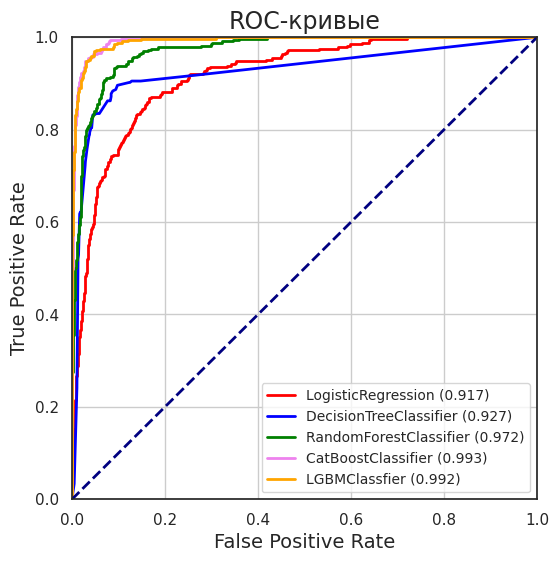

In [ ]:
plt.figure(figsize=(6, 6))

prob_lr = lr_best.predict_proba(features_test)[:,1]
prob_dt = dt_best.predict_proba(features_test)[:,1]
prob_rf = rf_best.predict_proba(features_test)[:,1]
prob_cb = cb_best.predict_proba(features_test)[:,1]
prob_lgb = lgb_best.predict_proba(features_test)[:,1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(target_test, prob_lr)
fpr_dt, tpr_dt, thresholds_dt = roc_curve(target_test, prob_dt)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(target_test, prob_rf)
fpr_cb, tpr_cb, thresholds_cb = roc_curve(target_test, prob_cb)
fpr_lgb, tpr_lgb, thresholds_lgb = roc_curve(target_test, prob_lgb)
plt.plot(fpr_lr, tpr_lr, color='red',
        lw=2, label='LogisticRegression (%0.3f)' % roc_auc_score(target_test, prob_lr))
plt.plot(fpr_dt, tpr_dt, color='blue',
        lw=2, label='DecisionTreeClassifier (%0.3f)' % roc_auc_score(target_test, prob_dt))
plt.plot(fpr_rf, tpr_rf, color = 'green',
        lw=2, label='RandomForestClassifier (%0.3f)' % roc_auc_score(target_test, prob_rf))
plt.plot(fpr_cb, tpr_cb, color = 'violet',
        lw=2, label='CatBoostClassifier (%0.3f)' % roc_auc_score(target_test, prob_cb))
plt.plot(fpr_lgb, tpr_lgb, color = 'orange',
        lw=2, label='LGBMClassfier (%0.3f)' % roc_auc_score(target_test, prob_lgb))

plt.plot([0, 1], [0, 1], color='navy', lw = 2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate', fontsize= 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('ROC-кривые', fontsize = 17)
plt.legend(fontsize = 10)
plt.grid()
plt.show()

### Влияние признаков

Оценим, какие признаки сильнее всего оказывают влияние на целевую переменную в лучшей из построенных моделей - CatBoost.

In [ ]:
# график сравнения влияния признаков

def draw_feature_importance(model):
    df = pd.DataFrame(model, features_train.columns).reset_index()\
            .rename(columns = {'index': 'features', 0: 'importance'}).sort_values(by='importance', ascending=False)
    plt.figure(figsize=(15, 15), dpi=60)
    ax = sns.barplot(x='importance', y='features', data=df)
    plt.title('Важность признаков', fontsize=20)
    plt.ylabel("Признаки", fontsize=10)
    plt.xlabel("Коэффициент", fontsize=10)
    plt.grid()

CatBoost


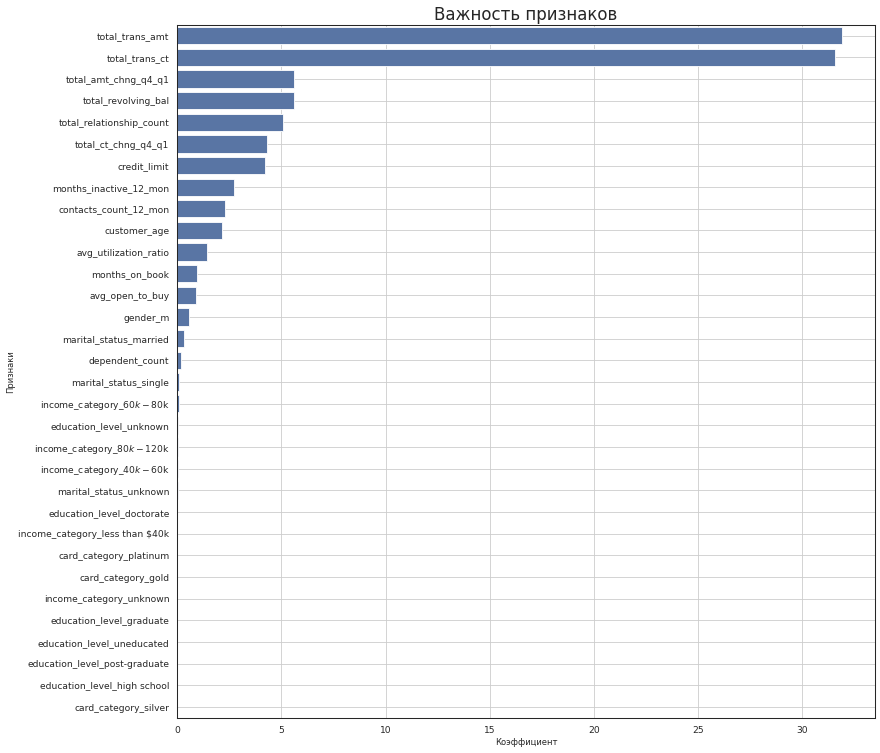

In [ ]:
print('CatBoost')
draw_feature_importance(cb_best.feature_importances_)

В целом результаты совпадают с выводами о значимости, полученных во время EDA.

Таким образом, основную роль играют общие сумма и число транзакций клиента за год. Некоторые признаки тоже значимы, но существенно менее важны: возобновляемый баланс, число продуктов у клиента, кредитный лимит и отношение суммы/числа активностей в 4-м кв. к 1-му кв.

Посмотрим, как изменится результат работы лучшей модели (CatBoost), если оставить только значимые признаки.

In [ ]:
df_fimp = df_mod[['total_trans_amt', 'total_trans_ct', 'total_amt_chng_q4_q1', 'total_ct_chng_q4_q1',\
                  'total_relationship_count', 'total_revolving_bal', 'credit_limit', 'attrition_flag']]

In [ ]:
targ_fimp = df_fimp['attrition_flag'].astype('int')
feat_fimp = df_fimp.drop('attrition_flag', axis=1)

In [ ]:
features_train_fimp, features_test_fimp, target_train_fimp, target_test_fimp = \
                                    train_test_split(feat_fimp, targ_fimp, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
scaler.fit(features_train_fimp)

features_train_fimp = scaler.transform(features_train_fimp)
features_test_fimp = scaler.transform(features_test_fimp)

In [ ]:
model_result(cb_best, features_train_fimp, features_test_fimp, target_train_fimp, target_test_fimp, result)
pd.DataFrame(result)

model  ROC-AUC  Accuracy       F1  Precision   Recall
0      LogisticRegression  0.91746   0.84896  0.64252    0.51985  0.84098
1  DecisionTreeClassifier  0.92650   0.90967  0.75826    0.66744  0.87768
2  RandomForestClassifier  0.97207   0.92744  0.79441    0.73196  0.86850
3      CatBoostClassifier  0.99334   0.96693  0.90103    0.87143  0.93272
4          LGBMClassifier  0.99245   0.96644  0.89881    0.87536  0.92355
5      CatBoostClassifier  0.98895   0.95953  0.88012    0.84314  0.92049

Количество признаков было сокращено втрое, при этом значение метрик уменьшилось всего на 0,003-0,03. Сильнее всего в качестве потеряла precision (0,03). В зависимости от точности, которую предъявляет бизнес, полученный результат может оказаться вполне приемлемым.

Проверим, какие признаки являются существенными для других моделей.

Для логистической регрессии:

Логистическая регрессия


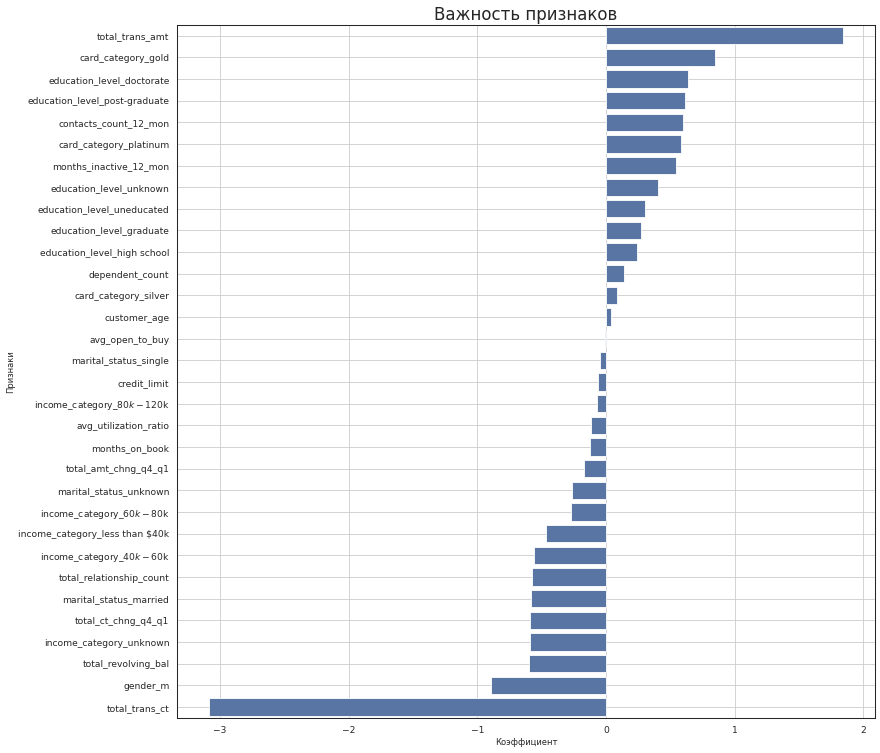

In [ ]:
print('Логистическая регрессия')
draw_feature_importance(lr_best.coef_[0])

Логистическая регрессия использует практически все признаки. Основное влияние по-прежнему оказывают общие сумма и число транзакций клиента за год. Однако, в отличие от других моделей, логистическая регрессия довольно активно использует и категориальные признаки (приведенные в числовую форму) - пол, тип карты, уровень образования и семейное положение.

Решающее дерево


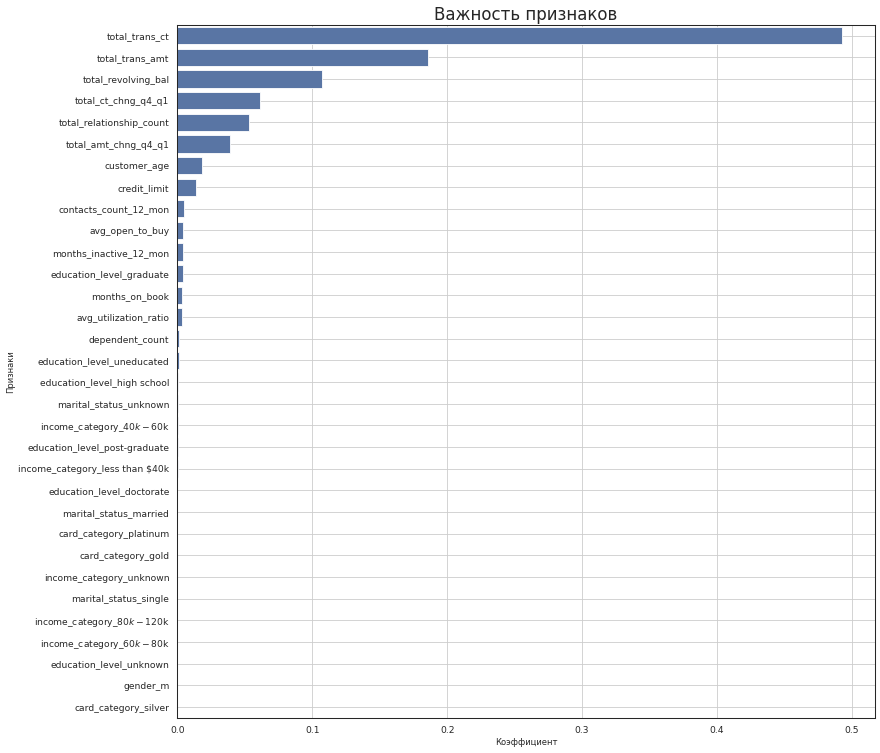

In [ ]:
print('Решающее дерево')
draw_feature_importance(dt_best.feature_importances_)

Для решающего дерева в основном значение имеют те же признаки, что и для CatBost.

Случайный лес


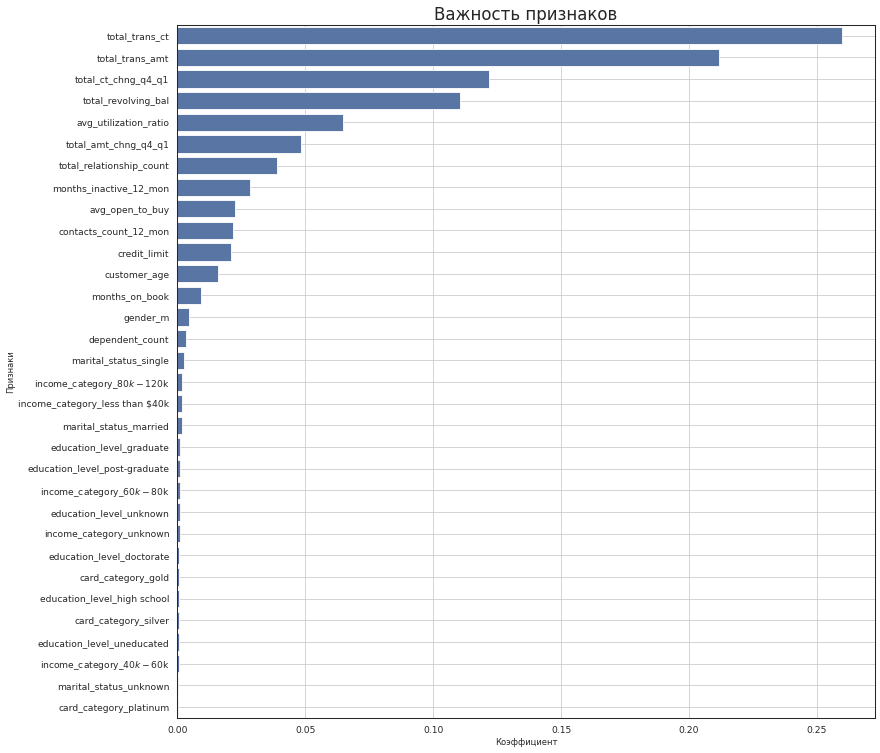

In [ ]:
print('Случайный лес')
draw_feature_importance(rf_best.feature_importances_)

Для случайного леса набор важных признаков в целом тот же. Добавились коэффициент использования лимита и число неактивных месяцев.

LightGBM


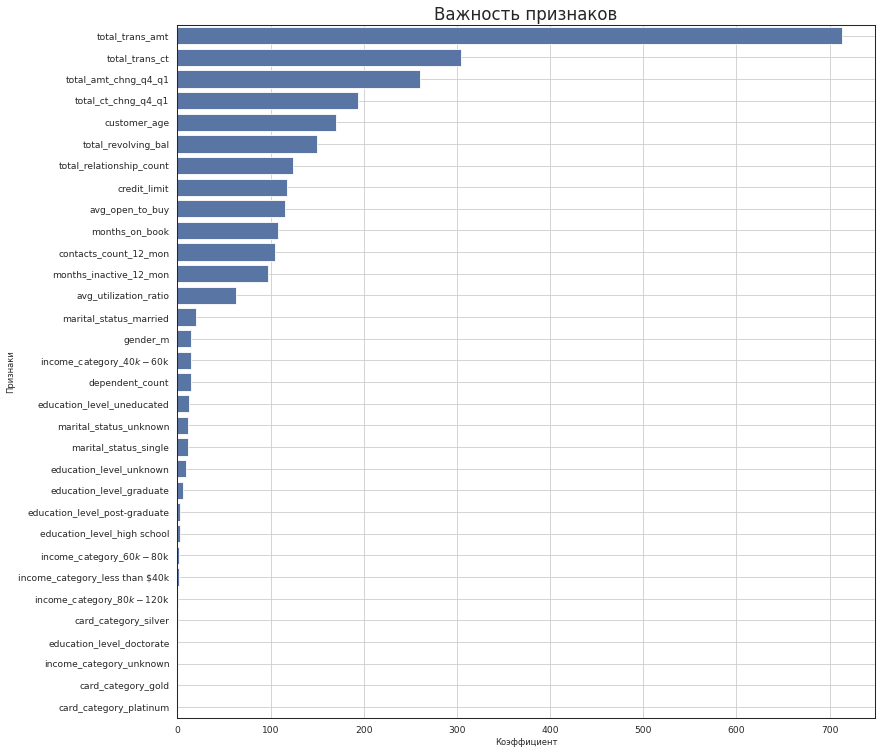

In [ ]:
print('LightGBM')
draw_feature_importance(lgb_best.feature_importances_)

У второй по резултату модели - LGBM - больше важных признаков, чем у CatBoost. Помимо перечисленных, она использует возраст клиента, срок, в течение которого он является клиентом, а также число контактов с клиентом за год.

### Вывод

Построены и обучены следующие модели:

- линейной регрессии;
- дерева решений;
- случайного леса;
- CatBoost;
- LightGBM.

Для обучения и оценки моделей датасет разбит на обучающую и тестовую выборки в пропорции 4:1.

Для каждой модели с помощью функции GridSerchCV подбиралиись оптимальные гиперпараметры: для логистической регрессии - значение обратной регуляризации, для решающего дерева - его глубина. Для остальных моделей - глубина и число деревьев.

Модели с оптимальными гиперпараметрами обучены на тренировочной и проверены на тестовой выборке.

В итоговой таблице два результата модели CatBoost: чуть менее высокий (разница ROC-AUC всего 0,0044) получился на датасете из всего семи основных признаков:
- общие сумма и число транзакций за последние 12 месяцев;
- разница в числе и сумме транзакций (4-й квартал по сравнению с 1-м)
- общее количество продуктов;
- кредитный лимит;
- размер возобновляемого остатка.

Немного пожертвовав  precision (разница 0,028), можно ускорить время обучения и работы модели, практически не потеряв в ключевой по условию метрике.

Лучшие результаты по качеству показали модели на основе градиентного бустинга. И ROC-AUC, и F1 на тысячные доли выше у CatBoost (0,993 и 0,901 соответственно против 0,992 и 0,900 у LightGBM).

Модели, основанные на деревьях решений, дают менее высокое значение метрик. ROC-AUC у случайного леса составил 0,972, а у дерева решений - 0,926.

Линейная регрессия уступает всем моделям и по качеству предсказаний (0,917), и по полноте (0,840).



## Кластеризация клиентов

Попробуем кластеризовать клиентов. Для этого будем использовать матрицу признаков без целевой переменой оттока. Оставим только те признаки, которые большинство моделей считает значимыми:
- общие сумму и число транзакций за последние 12 месяцев;
- разницу в числе и сумме транзакций (4-й квартал по сравнению с 1-м);
- кредитный лимит;
- размер возобновляемого остатка;
- коэффициент использования карты;
- количество месяцев за последний год, в течение которых клиент был неактивным;
- общее количество продуктов.

Стандартизируем данные:

In [ ]:
features = df_mod[['total_trans_amt', 'total_trans_ct', 'total_amt_chng_q4_q1', 'total_ct_chng_q4_q1',\
                  'total_relationship_count', 'total_revolving_bal', 'credit_limit', 'months_inactive_12_mon', 'avg_utilization_ratio']]

target = df_mod['attrition_flag'].astype('int')

In [ ]:
sc = StandardScaler()
features_sc = sc.fit_transform(features)

Построим матрицу расстояний на стандартизованной матрице признаков и выведем дендрограмму:

In [ ]:
linked = linkage(features_sc, method='ward')

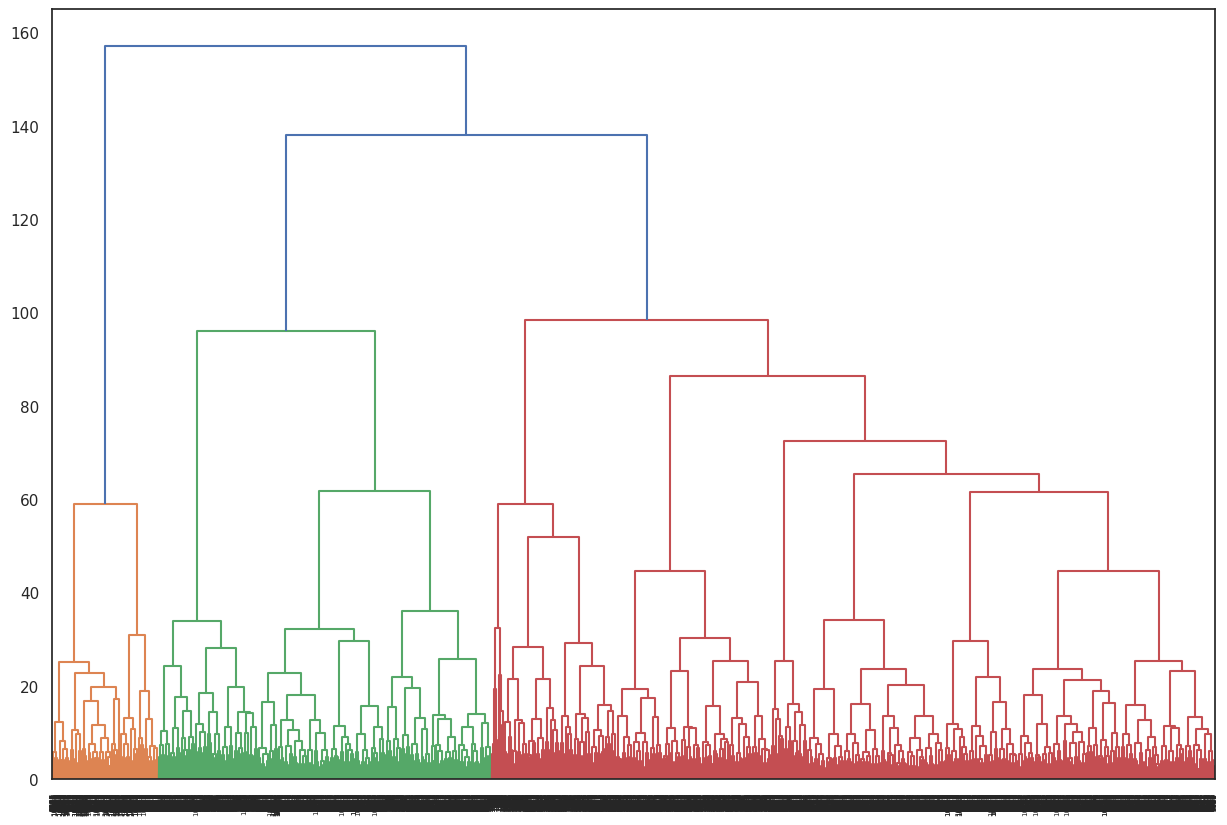

In [ ]:
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.show()

На дендрограмме выделяются 3 кластера.

Спрогнозируем кластеры на основании алгоритма K-means:

In [ ]:
km = KMeans(n_clusters=3, random_state=42)
labels = km.fit_predict(features_sc)
features['cluster_km'] = labels

Выведем статистику по средним значениям признаков по кластеру. Так как не все распределения нормалные, ориентируемся и на среднее арифметическое, и на медиану.

In [ ]:
display(features.groupby('cluster_km').agg(['mean', 'median']))

total_trans_amt          total_trans_ct         \
                      mean   median           mean median   
cluster_km                                                  
0             11953.262907  13648.0     101.213662  101.0   
1              3503.043083   3918.5      62.497205   67.0   
2              3172.050066   3059.5      57.068868   59.0   

           total_amt_chng_q4_q1        total_ct_chng_q4_q1         \
                           mean median                mean median   
cluster_km                                                          
0                      0.775949  0.761            0.724379  0.722   
1                      0.791955  0.752            0.760634  0.732   
2                      0.725480  0.710            0.663428  0.655   

           total_relationship_count        total_revolving_bal          \
                               mean median                mean  median   
cluster_km                                                               
0                          2.108817    2.0         1387.892772  1476.0   
1                          4.095715    4.0         1686.575221  1670.5   
2                          4.015741    4.0          609.162003     0.0   

            credit_limit          months_inactive_12_mon         \
                    mean   median                   mean median   
cluster_km                                                        
0           15479.427323  11642.0               2.213662    2.0   
1            3920.246111   2896.5               2.307173    2.0   
2           11170.454591   7595.5               2.408177    2.0   

           avg_utilization_ratio         
                            mean median  
cluster_km                               
0                       0.162600  0.103  
1                       0.535908  0.551  
2                       0.060767  0.000

Убедимся, что все клиенты были распределены по кластерам:

In [ ]:
display(features.groupby('cluster_km')['total_trans_amt'].agg(['count']))

count
cluster_km       
0            1259
1            4294
2            4574

Посмотрим, сколько отточных клиентов попало в каждый из кластеров:

In [ ]:
t = features.join(target)
display(t.groupby('cluster_km')['attrition_flag'].agg(['mean']))
display(t.query('attrition_flag == 1').groupby('cluster_km')['attrition_flag'].agg(['count']))

mean
cluster_km          
0           0.066720
1           0.080578
2           0.261697

count
cluster_km       
0              84
1             346
2            1197

Основная часть клиентов из группы с оттоком (73% от их общего числа) сконцентрирована в последнем кластере. Во всем датасете доля отточных клиентов составляла 16%, при этом в первом и втором кластерах она оказалась на уровне 6% и 8% соответственно, а в последнем - 26%.


### Вывод

Кластер посетителей с минимальным оттоком (№ 1) характеризуется следующими особенностями:

- средняя общая сумма операций за последний год в 4 раза выше. чем в других кластерах (12000 долл. против 3100 долл. и 3500 долл.);
- среднее количество операций за последний год также существенно выше (101 против 62 и 57);
- минимальное число продуктов, которыми пользуется клиент (два против четырех в двух других группах);
- достаточно большой размер возобновляемого остатка, хотя и не максимальный (1388 долл., а в отточной группе - 609 долл.);
- макмимальный размер кредитного лимита (15500 долл. против 3920 и 11170 долл.);
- самое низкое среднее значение неактивных месяцев (2,2);
- относительно низкий относительно второй группы коэффициент использования лимита (16% против 53%). Однако это вызвано, в том числе и тем, что во второй группе размер лимита ниже практически в 4 раза.


Ценным для бизнеса также выглядит кластер №2: при доле оттоке в 8% он весомый по численности (42% посетителей). Его характеристики:

- лучшие показатели отношения суммы и числа транзакций в 4 квартале к 1-му кварталу. Эти клиенты меньше всего снизили свою активность по лимиту;
- максимальное среднее число продуктов на клиента (4,1);
- максимальный размер возобновляемого остатка (1686 долл.);
- минимальный размер кредитного лимита (всего 3920 долл., тогда как в остальных группах 15500 и 11170 долл.);
- наибольшее значение коэффициента использования лимита - 50%.

Кластер с худшими показателями по оттоку №3 (26% общая доля; 73% - доля всех отточных клиентов датасета) обладает следующими чертами:

- минимальные общие сумма и количество операций за последний год;
- худшая динамика по сумме и числу транзакций от первого к четвертому кварталу;
- при этом сопоставимое со второй группой число продуктов банка, которыми пользуется клиент;
- среднее значение возобновляемого остатка в 2,5-3 ниже, чем в других кластерах, причем медианное - вообще 0.
- достаточно высокий кредитный лимит (11170 долл.);
- самое большое среднее значение по числу неактивных месяцев (2,4);
- самый низкий коэффициент использования кредитной карты - всего 6%.

## Рекомендации по работе с клиентами

Стратегию работы с клиентами можно предложить, исходя из закономерностей, выявленных для кластеров с минимальным оттоком (№1 и №2). Вообще говоря, можно предположить несколько причин, по которым клиенты снижают использование кредитных карт:

1. Ухудшение финансового состояния. Такие клиенты стараются покупать только самое необходимое, уменьшая уровень потребления, в том числе и по кредитным картам. Таких заемщиков можно определить, проанализировав в динамике данные об уровне их дохода. Эта категория является малопривлекательной для банковского бизнеса. Напротив, существует риск роста просроченной задолженности, поэтому, таким клиентам может быть предпочтительнее снижать или вовсе закрыть кредитный лимит.

2. Переход на услуги банка-конкурента. Зачастую потребители отказываются от услуг своего основного банка не в один момент, а переводят обороты и расчеты в другую кредитную организацию постепенно. Снижение транзакций можно заметить, отслеживая их динамику с определенной периодичностью. Поскольку, как правило, проще и дешевле удержать действующего клиента, чем привлечь нового, эта группа и является основной для проработки с целью снижения оттока. Так, можно предложить следующие мероприятия:
- привязка клиента к банку через другие продукты, в том числе долгосрочные (инвестиционные инструменты, ипотека, автокредиты);
- привязка клиента к банку через привлечение на обслуживание членов его семьи;
- стимулирование транзакций, в том числе по кредитной карте, через различные программы лояльности (повышенный кэшбек, партнерские программы, рекламные кампании с подарками от банка и пр.);
- увеличение кредитного лимита, если финансовое состояние заемщика позволяет это сделать.









# **Основные результаты**

В работе решалась задача анализа и прогнозирования оттока клиентов банка, пользующихся кредитными картами. Группа клиентов в оттоке составляет 16% от всей выборки (10127 человек).

В ходе предварительного анализа данных проведен исследовательский анализ каждого признака в разрезе целевой переменной оттока:
- сильнее всего группы отличаются друг от друга по признакам, харакеризующим активность клиента в банке вообще и по кредитному лимиту в частности:
  - размер лимита (среднее 8726 долл. в группе без оттока, 8136 долл. - в группе с оттоком);
  - размер остатка на счете (среднее 1256 долл. в группе без оттока, 672 долл. - в группе с оттоком);
  - число продуктов (среднее 3,91 в группе без оттока, 3,27 - в группе с оттоком);
  - количеству неактивных месяцев (среднее 2,3 в группе без оттока, 2,7 - в группе с оттоком);
  - коэффициент использования лимита (среднее 0,29 в группе без оттока, 0,16 - в группе с оттоком);
  - общая сумма и число транзакций за последний год (среднее 4654 долл. и 68 шт. в группе без оттока, 3095 долл. и 44 шт. - в группе с оттоком);
  - отношение суммы и числа транзакций в 4 квартале к первому кварталу (среднее 0,77 и 0,74 соответственно в группе без оттока, 0,69 и 0,55 соответственно - в группе с оттоком);
- менее явная связь с годовым доходом, семейным положением, полом клиента;
- отсутствует связь со следующими признаками: возраст, число иждивенцев, уровень образования, тип кредитной карты, срок нахождения в статусе клиента, разница между размером лимита и балансом счета.

- с помощью статистических тестов подтверждена значимость кредитного лимита и опровергнута - возраста и срока обслуживания в банке;
- рассчитаны коэффициенты корреляции между переменными;
---

Для решения задачи прогнозирования оттока обучены и протестированы модели:
- линейной регрессии;
- дерева решений;
- случайного леса;
- CatBoost;
- LightGBM.

Датасет разделен на тренировочную и тестовую выборки в пропорции 4:1. Данные стандартизированы. В качестве основной метрики использовалась ROC-AUC, вспомогательных - F1 и recall.

Для каждой модели с помощью функции GridSerchCV подбиралиись оптимальные гиперпараметры: для логистической регрессии - значение обратной регуляризации, для решающего дерева - его глубина. Для остальных моделей - глубина и число деревьев. Модели с оптимальными гиперпараметрами обучены на тренировочной и проверены на тестовой выборке.

Линейная регрессия уступает всем моделям и по качеству предсказаний (0,917), и по полноте (0,840).

Модели, основанные на деревьях решений, дают менее высокое значение метрик. ROC-AUC у случайного леса составил 0,972, а у дерева решений - 0,926.

Лучшие результаты по качеству показали модели на основе градиентного бустинга. И ROC-AUC, и F1 на тысячные доли выше у CatBoost (0,993 и 0,901 соответственно против 0,992 и 0,900 у LightGBM).

Сравнение моделей по важности признаков показало, что для бустинговых моделей значимыми являются только треть от общего их количества: общие сумма и число транзакций за последние 12 месяцев, разница в числе и сумме транзакций (4-й квартал по сравнению с 1-м), общее количество продуктов, кредитный лимит, размер возобновляемого остатка.

Результат работы лучшей модели (CatBoost) на датасете с указанными признаками - уступил по ROC-AUC всего 0,0044 работе этой же модели на полном датасете.
Немного пожертвовав  precision (разница 0,028), можно ускорить время обучения и работы модели, практически не потеряв в ключевой по условию метрике.

---

На основании значимых для целевой переменной оттока признаков клиенты разделены на три кластера:

1. Наиболее многообещающая группа с максимальными суммой (в 4 раза выше, чем в других кластерах) и числом операций по кредитной карте и наибольшим значением лимита. Доля оттока составляет всего 6%. Перспективы для развития - увеличение числа продуктов на клиента (по сравнению с другими группами оно ниже вдвое: 2 против 4) и стимулирование дальнейшего роста числа операций по кредитной карте.

2. Интересны для банка, поскольку доля клиентов в оттоке также значительно ниже, чем в среднем по выборке (8% против 16%). У клиентов из этого кластера лучшие показатели отношения суммы и числа транзакций в 4 квартале к 1-му кварталу. Активность по лимиту снизилась меньше, чем в других группах. Эти клиенты активно пользуются продуктами банка (максимальное количество - 4,1 шт.), а также кредитным лимитом в частности (коэффициент использования лимита - 50%). Вместе с тем, размер лимита в этом кластере значительно ниже, чем в других, что может быть говорить о недостаточно прочном финансовом положении. Решения об увеличении лимита следует принимать с осторожностью. Вместе с тем, это группа лояльных банку клиентов, увеличивать доходность от которых могут помочь другие продукты.

3. В третьей группе сконцентрирована основная отточная часть клиентов (73% от общего числа в выборке). Эти клиенты реже и меньше всех пользуются лимитом, несмотря на достаточно высокий его уровень. Характеризуются большим числом продуктов (практически как во второй группе), то есть достаточно лояльны к банку. Вероятно, в этот кластер попали либо состоятельные клиенты, которым банк одобряет высокий лимит, но они предпочитают рассчитываться собственными средствами, либо, возможно, параллельно пользуются кредитной картой в другом банке. В этом случае рекомендуется провести маркетинговую кампанию, посвященную кредитным картам, а также проанализировать, кредитными картами каких еще банков пользуются клиенты,сравнить условия и выйти с более выгодным предложением к клиентам, если это оправдано с точки зрения финансового результата.



